# HQE Library

## Introduction

In this notebook, we present an implementation of the gates for the HQE implementation proposed by Liam. We add the implementation of unary gates for the qu-4-it representation.

This representation is defined by 4 modes and one photon:

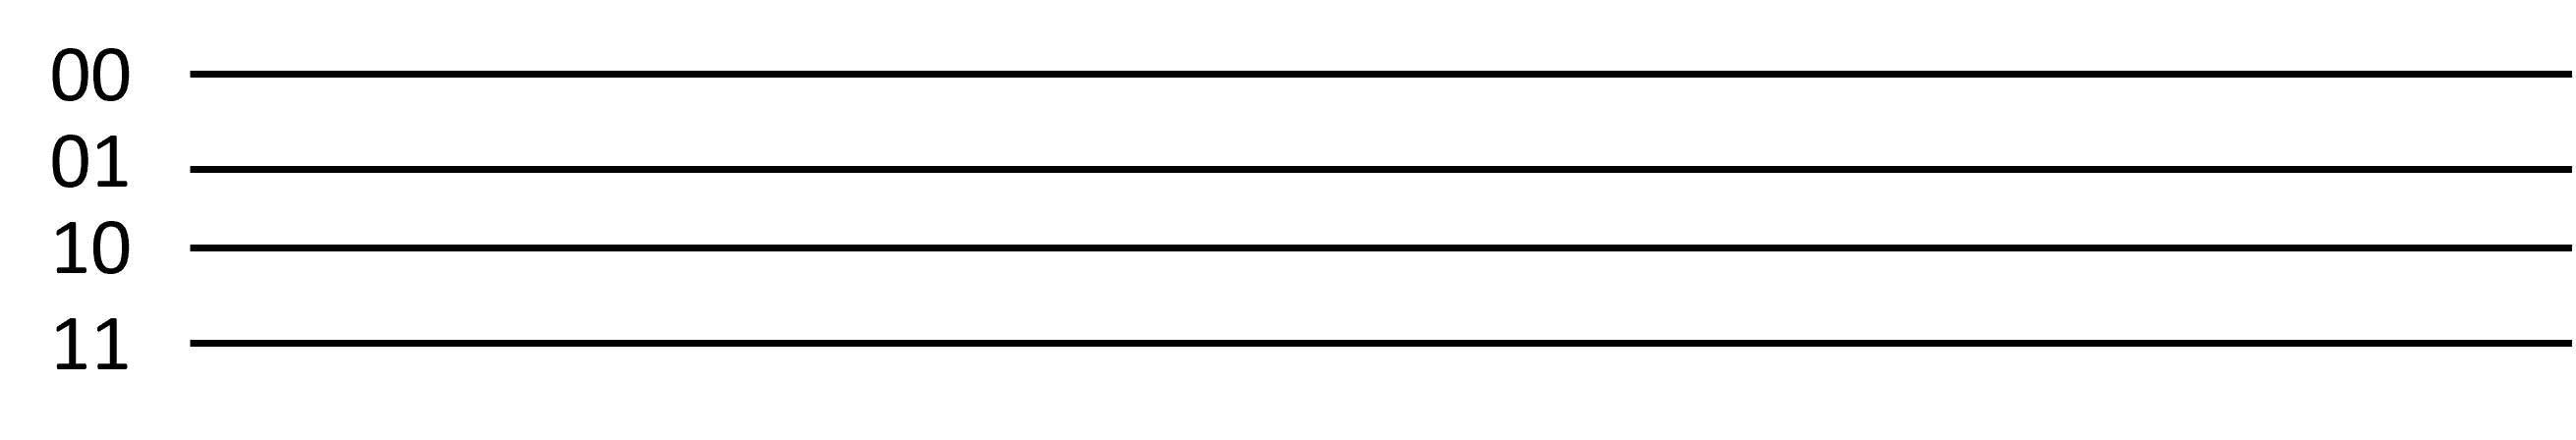

The value of the pair of qubits is defined by the location of the photon.

One advantage of this approach is that the two-qubit gates can be implemented deterministically, as shown below. Moreover, as shown by Liam, many multi-gate operations can be implemented with a high probability of success (a small power of $\frac{2}{27}$, the success probability of a knill CZ). However, one-qubit gates become less intuitive. Therefore, we also propose implementation of one-qubit gates acting on the qubits of the qu-4-it.

Below, we follow the convention that, for the qu-4-it $\text{ab}$, $\text{a}$ is the $0^{\text{th}}$ qubit and $\text{b}$ is the $1^{\text{st}}$ qubit.

Nevertheless, qu-4-its are not optimal alone. We can indeed obtain an improved success probability through an approach combining qu-4-its and dual rail qubits.

One problem that is not solved here is how to define *efficiently* the correspondance between the circuit qubits in the one hand and the qu-4-it and dual rail representation on the other hand. In this notebook, the correspondance has been done manually.

## Initialization

We start by importing the required modules.

In [216]:
import perceval as pcvl
import perceval.lib.phys as phys
import numpy as np
import qiskit
import sklearn.metrics as sm
from sklearn import datasets
import random as rd
import itertools
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import collections

## The Deterministic gates

The deterministic gates correspond to the gates that can be defined by **one** photon, i.e. unary and binary gates.

### The NOT gates

The NOT gates (NOT on the first or second qubit in the qu-4-it) can easily be defined through permutations of the modes.

In [2]:
def NOT0():
    """
    Defines the NOT gate on the first qubit of the qu-4-it.
    """
    circ = phys.Circuit(4, name="NOT")
    circ.add((0,1,2,3), phys.PERM([2,3,0,1]))
    return circ

def NOT1():
    """
    Defines the NOT gate on the second qubit of the qu-4-it.
    """
    circ = phys.Circuit(4, name="NOT")
    circ.add((0,1,2,3), phys.PERM([1,0,3,2]))
    return circ

In [642]:
circ=NOT0()
pcvl.pdisplay(circ)

In [643]:
circ=NOT1()
pcvl.pdisplay(circ)

### The CNOT gate

The advantage of the qu-4-it appears in binary gates such as CNOT that can be defined by the permutation of one pair of modes.

Here, we supposed that the first qubit is the control qubit and the second the target qubit.

In [6]:
def CNOT():
    """
    Defines the CNOT gate on a qu-4it.
    """
    circ=phys.Circuit(4, name="CNOT")
    circ.add((0,1,2,3), phys.PERM([0,1,3,2]))
    return circ

In [644]:
circ=CNOT()
pcvl.pdisplay(circ)

### The Hadamard gates

In the dual rail representation, Hadamard gates can be implemented by a beam splitter. In the qu-4-it representation however, we need to apply those gates on the appropriate pairs of modes as shown below.

In [14]:
def H0():
    """
    Defines the Hadamard gate on the first qubit of the qu-4-it.
    """
    circ = phys.Circuit(4, name="HADA")
    circ.add((0,1,2,3), phys.PERM([0,2,1,3])) 
    circ.add((0, 1), phys.BS(R=1/2))
    circ.add((2, 3), phys.BS(R=1/2))
    circ.add((0,1,2,3), phys.PERM([0,2,1,3])) 
    return circ

def H1():
    """
    Defines the Hadamard gate on the second qubit of the qu-4-it.
    """
    circ = phys.Circuit(4, name="HADA")
    circ.add((0, 1), phys.BS(R=1/2))
    circ.add((2, 3), phys.BS(R=1/2))
    return circ

In [645]:
circ=H0()
pcvl.pdisplay(circ)

In [646]:
circ=H1()
pcvl.pdisplay(circ)

### The $\text{R}_{\text{z}}$ gates

The $\text{R}_{\text{z}}$ gate is defined by the matrix:

\begin{equation*}
\text{R}_{\text{z}}(\theta) = \begin{pmatrix}
                                e^{-i \frac{\theta}{2}} & 0\\
                                0 & e^{i \frac{\theta}{2}}
                                \end{pmatrix} = \text{exp}\left(-i \frac{\theta}{2} \text{Z}\right)
\end{equation*}

This gate can easily be defined using the appropriate phase shifters.

In [17]:
def R_z0(phi):
    """
    Defines the R_z(phi) gate applied on the first qubit of the qu-4-it.
    """
    circ = phys.Circuit(4, name="R_z")
    circ.add(0, phys.PS(-phi/2))
    circ.add(1, phys.PS(-phi/2))
    circ.add(2, phys.PS(phi/2))
    circ.add(3, phys.PS(phi/2))
    return circ
    
def R_z1(phi):
    """
    Defines the R_z(phi) gate applied on the second qubit of the qu-4-it.
    """
    circ = phys.Circuit(4, name="R_z")
    circ.add(0, phys.PS(-phi/2))
    circ.add(1, phys.PS(phi/2))
    circ.add(2, phys.PS(-phi/2))
    circ.add(3, phys.PS(phi/2))
    return circ

In [647]:
circ=R_z0(np.pi/3)
pcvl.pdisplay(circ)

In [648]:
circ=R_z1(np.pi/3)
pcvl.pdisplay(circ)

### The $\text{R}_{\text{x}}$ gates

The $\text{R}_{\text{x}}$ gate is defined by the matrix:

\begin{equation*}
\text{R}_{\text{x}}(\theta) = \begin{pmatrix}
                                \text{cos}\left(\frac{\theta}{2}\right) & -i \ \text{sin}\left(\frac{\theta}{2}\right)\\
                                -i \ \text{sin}\left(\frac{\theta}{2}\right) & \text{cos}\left(\frac{\theta}{2}\right)
                                \end{pmatrix} = \text{exp}\left(-i \frac{\theta}{2} \text{X}\right)
\end{equation*}

$\text{R}_{\text{x}}(\theta)$ can be implemented by applying a Hadamard gate on each side of the $\text{R}_{\text{z}}(\theta)$ gate since:

\begin{equation*}
\text{X} = \text{H Z H}
\end{equation*}

In [26]:
def R_x0(phi):
    """
    Defines the R_x(theta) gate applied on the first qubit of the qu-4-it.
    """
    circ=phys.Circuit(4, name="R_x")
    circ.add((0,1,2,3), phys.PERM([0,2,1,3])) 
    circ.add((0, 1), phys.BS(R=1/2))
    circ.add((2, 3), phys.BS(R=1/2))
    circ.add((0,1,2,3), phys.PERM([0,2,1,3])) 
    circ.add(0, phys.PS(-phi/2))
    circ.add(1, phys.PS(-phi/2))
    circ.add(2, phys.PS(phi/2))
    circ.add(3, phys.PS(phi/2))
    circ.add((0,1,2,3), phys.PERM([0,2,1,3])) 
    circ.add((0, 1), phys.BS(R=1/2))
    circ.add((2, 3), phys.BS(R=1/2))
    circ.add((0,1,2,3), phys.PERM([0,2,1,3])) 
    return circ

def R_x1(phi):
    """
    Defines the R_x(theta) gate applied on the second qubit of the qu-4-it.
    """
    circ=phys.Circuit(4, name="R_x")
    circ.add((0, 1), phys.BS(R=1/2))
    circ.add((2, 3), phys.BS(R=1/2))
    circ.add(0, phys.PS(-phi/2))
    circ.add(1, phys.PS(phi/2))
    circ.add(2, phys.PS(-phi/2))
    circ.add(3, phys.PS(phi/2))
    circ.add((0, 1), phys.BS(R=1/2))
    circ.add((2, 3), phys.BS(R=1/2))
    return circ

In [649]:
circ=R_x0(np.pi/3)
pcvl.pdisplay(circ)

In [650]:
circ=R_x1(np.pi/3)
pcvl.pdisplay(circ)

### The $\text{R}_{\text{y}}$ gates

The $\text{R}_{\text{y}}$ gate is defined by the matrix:

\begin{equation*}
\text{R}_{\text{y}}(\theta) = \begin{pmatrix}
                                \text{cos}\left(\frac{\theta}{2}\right) & -\text{sin}\left(\frac{\theta}{2}\right)\\
                                \text{sin}\left(\frac{\theta}{2}\right) & \text{cos}\left(\frac{\theta}{2}\right)
                                \end{pmatrix} = \text{exp}\left(-i \frac{\theta}{2} \text{Y}\right)
\end{equation*}

$\text{R}_{\text{y}}(\theta)$ can be implemented by applying tunable beam splitters on each side of the $\text{R}_{\text{z}}(\theta)$ gate since:

\begin{equation*}
Y = \tilde{H}^\dagger Z \tilde{H},
\end{equation*}

where:

\begin{equation*}
\tilde{H} = \frac{1}{\sqrt{2}} \begin{pmatrix}
                                1 & 1\\
                                i & -i
                                \end{pmatrix}
\end{equation*}

In [634]:
def R_y0(phi):
    """
    Defines the R_y(theta) gate applied on the first qubit of the qu-4-it.
    """
    circ=phys.Circuit(4, name="R_y")
    circ.add((0,1,2,3), phys.PERM([0,2,1,3]))
    circ.add((0, 1), phys.BS(R=1/2,phi_a=0,phi_b=-np.pi/2,phi_d=-np.pi/2))
    circ.add((2, 3), phys.BS(R=1/2,phi_a=0,phi_b=-np.pi/2,phi_d=-np.pi/2))
    circ.add((0,1,2,3), phys.PERM([0,2,1,3])) 
    circ.add(0, phys.PS(-phi/2))
    circ.add(1, phys.PS(-phi/2))
    circ.add(2, phys.PS(phi/2))
    circ.add(3, phys.PS(phi/2))
    circ.add((0,1,2,3), phys.PERM([0,2,1,3])) 
    circ.add((0, 1), phys.BS(R=1/2, phi_a=0,phi_b=-np.pi,phi_d=np.pi/2))
    circ.add((2, 3), phys.BS(R=1/2, phi_a=0,phi_b=-np.pi,phi_d=np.pi/2))
    circ.add((0,1,2,3), phys.PERM([0,2,1,3])) 
    return circ

def R_y1(phi):
    """
    Defines the R_y(theta) gate applied on the second qubit of the qu-4-it.
    """
    circ=phys.Circuit(4, name="R_y")
    circ.add((0, 1), phys.BS(R=1/2,phi_a=0,phi_b=-np.pi/2,phi_d=-np.pi/2))
    circ.add((2, 3), phys.BS(R=1/2,phi_a=0,phi_b=-np.pi/2,phi_d=-np.pi/2))
    circ.add(0, phys.PS(-phi/2))
    circ.add(1, phys.PS(phi/2))
    circ.add(2, phys.PS(-phi/2))
    circ.add(3, phys.PS(phi/2))
    circ.add((0, 1), phys.BS(R=1/2, phi_a=0,phi_b=-np.pi,phi_d=np.pi/2))
    circ.add((2, 3), phys.BS(R=1/2, phi_a=0,phi_b=-np.pi,phi_d=np.pi/2))
    return circ

In [651]:
circ=R_y0(np.pi/3)
pcvl.pdisplay(circ)

In [652]:
circ=R_y1(np.pi/3)
pcvl.pdisplay(circ)

### The $\sqrt{\text{X}}$ gates

This gate is the square root of the NOT gate. It can be defined by a $\text{R}_{\text{x}}$ gate.

In [28]:
def SX0():
    return R_x0(np.pi/2)
def SX1():
    return R_x1(np.pi/2)

In [653]:
circ=SX0()
pcvl.pdisplay(circ)

In [654]:
circ=SX1()
pcvl.pdisplay(circ)

### The phase gates

The phase gates are defined by:

\begin{equation*}
\text{P}(\theta)=\begin{pmatrix}
                   1 & 0\\
                   0 & e^{i \theta}
                   \end{pmatrix}
\end{equation*}

This gate can easily be implemented using phase shifters in the appropriate modes.

In [31]:
def P0(phi):
    """
    Defines the P(phi) gate on the first qubit of the qu-4-it.
    """
    circ=phys.Circuit(4, name="P")
    circ.add(2, phys.PS(phi))
    circ.add(3, phys.PS(phi))
    return circ

def P1(phi):
    """
    Defines the P(phi) gate on the second qubit of the qu-4-it.
    """
    circ=phys.Circuit(4, name="P")
    circ.add(1, phys.PS(phi))
    circ.add(3, phys.PS(phi))
    return circ

In [655]:
circ=P0(np.pi/4)
pcvl.pdisplay(circ)

In [656]:
circ=P1(np.pi/4)
pcvl.pdisplay(circ)

### The Z gates

We define the $\text{Z}$ gate using phase gates because:

\begin{equation*}
\text{Z} = \text{P}(\pi)
\end{equation*}

In [34]:
def Z0():
    """
    Defines the Z gate acting on the first qubit of the qu-4-it.
    """
    return P0(np.pi)

def Z1():
    """
    Defines the Z gate acting on the second qubit of the qu-4-it.
    """
    return P1(np.pi)

In [657]:
circ=Z0()
pcvl.pdisplay(circ)

In [658]:
circ=Z1()
pcvl.pdisplay(circ)

### The S gates

We define the $\text{S}$ gate using phase gates because:

\begin{equation*}
\text{S} = \text{P}\left(\frac{\pi}{2}\right)
\end{equation*}

In [37]:
def S0():
    """
    Defines the S gate acting on the first qubit of the qu-4-it.
    """
    return P0(np.pi/2)

def S1():
    """
    Defines the S gate acting on the second qubit of the qu-4-it.
    """
    return P1(np.pi/2)

In [659]:
circ=S0()
pcvl.pdisplay(circ)

In [660]:
circ=S1()
pcvl.pdisplay(circ)

### The $S^\dagger$ gates

We define the $S^\dagger$ gate using phase gates because:

\begin{equation*}
\text{S} = \text{P}\left(-\frac{\pi}{2}\right)
\end{equation*}

In [373]:
def Sd0():
    """
    Defines the S gate acting on the first qubit of the qu-4-it.
    """
    return P0(-np.pi/2)

def Sd1():
    """
    Defines the S gate acting on the second qubit of the qu-4-it.
    """
    return P1(-np.pi/2)

In [661]:
circ=Sd0()
pcvl.pdisplay(circ)

In [662]:
circ=Sd1()
pcvl.pdisplay(circ)

### The T gates

We define the $\text{T}$ gate using phase gates because:

\begin{equation*}
\text{T} = \text{P}\left(\frac{\pi}{4}\right)
\end{equation*}

In [40]:
def T0():
    """
    Defines the T gate acting on the first qubit of the qu-4-it.
    """
    return P0(np.pi/4)

def T1():
    """
    Defines the T gate acting on the second qubit of the qu-4-it.
    """
    return P1(np.pi/4)

In [663]:
circ=T0()
pcvl.pdisplay(circ)

In [664]:
circ=T1()
pcvl.pdisplay(circ)

### The $T^\dagger$ gates

We define the $T^\dagger$ gate using phase gates because:

\begin{equation*}
\text{T} = \text{P}\left(-\frac{\pi}{4}\right)
\end{equation*}

In [381]:
def Td0():
    """
    Defines the T gate acting on the first qubit of the qu-4-it.
    """
    return P0(-np.pi/4)

def Td1():
    """
    Defines the T gate acting on the second qubit of the qu-4-it.
    """
    return P1(-np.pi/4)

In [665]:
circ=Td0()
pcvl.pdisplay(circ)

In [666]:
circ=Td1()
pcvl.pdisplay(circ)

### The controlled phase shift gates

Here again, the advantage of our approach appears. This gate is hard to implement in a dual rail representation. In the qu-4-t representation, it can be implemented by applying one phase sifter.

In [45]:
def CP(phi):
    """
    Defines a CP(phi) gate on a qu-4-it.
    """
    circ=phys.Circuit(4, name="CP")
    circ.add(3, phys.PS(phi))
    return circ

In [667]:
circ=CP(np.pi/4)
pcvl.pdisplay(circ)

### CZ

The qu-4-it CZ gate is a particular case of the CP gate.

In [47]:
def CZ():
    """
    Defines the CZ gate on the qu-4-it.
    """
    return CP(np.pi)

In [668]:
circ=CZ()
pcvl.pdisplay(circ)

### The SWAP gate

As in the case of dual rail representation, the SWAP gate can be defined using permutations of modes.

In [405]:
def SWAP():
    """
    Defines a SWAP gate acting on a qu-4-it.
    """
    circ=pcvl.Circuit(4, name="SWAP")
    circ.add((0,1,2,3), phys.PERM([0,2,1,3]))
    return circ

In [669]:
circ=SWAP()
pcvl.pdisplay(circ)

### Examples

#### The Bell State

The commonly called Bell state is in reality the first of the four Bell states. It is defined as:

\begin{equation*}
\frac{|00> + |11>}{\sqrt{2}}
\end{equation*}

This state was important in the history of quantum mechanics since it is the first *entangled state*.

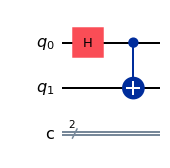

In [55]:
qc = qiskit.QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.draw("mpl", style="iqx")

In [671]:
circ=H0()
circ.add((0,1,2,3),CNOT())
pcvl.pdisplay(circ,recursive=True)

#### Reversing the roles - Reversed CNOT

In order to reverse the roles of the two qubits in a qu-4-it, we only need to apply a SWAP on both sides of our gates. It is not optimal, but it is a simple and automatic process.

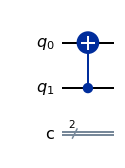

In [59]:
qc = qiskit.QuantumCircuit(2,2)
qc.cx(1,0)
qc.draw("mpl", style="iqx")

In [673]:
circ=SWAP().add((0,1,2,3),CNOT()).add((0,1,2,3),SWAP())
pcvl.pdisplay(circ,recursive=True)

## Probabilistic gates

Probabilistic gates are gates that require the entanglement of two or more photons. Since this entanglement cannot be easily controlled, not all outputs are desirable. Consequently, the gate is designed in a way that its output is controlled by selecting some kinds of outputs in the **ancilla** modes.

The probability of success of the gate is defined as the probability of measuring the desired ancilla output.

For our application, the ancilla measurements require *number resolving detection*.


#### Defaults

Additional to the need for post-selection and the use of a very small portion of all outputs, which are problems in themselves, our approach has some defaults that it may be useful to point out in order to solve them.

One default of our approach is that the classical simulation of the circuits takes a lot of time. This situation may have a *silver linining*: the problem may be easier to simulate on a photonic circuit. The second default is that for each application of the Knill CZ gate (cf. below), two ancilla modes and two photons are required. Indeed, the ancilla modes **cannot** be recycled since we use them for post-selection.

### Knill CZ gate

Liam based his probabilistic gates on the knill CZ gate. This gate is used in the dual rail representation for implementing the CZ gate (the qu-4-it approach allows for a determinstic implementation).

It uses two ancilla modes each containing one photon. The gate applies a global $\pi$ phase when there is a photon in the control and target modes.

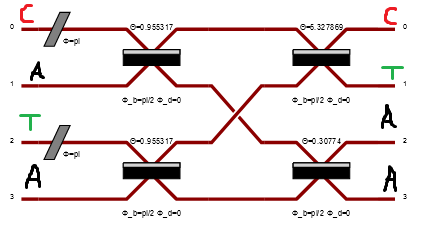

Of course, the control and target modes play symmetric roles.

The probability of success of this probabilistic gate is: $\frac{2}{27} \approx 0.074$.

One should watch out that the input and output modes are **NOT** in the same order.

In [88]:
def KZ():
    circ = phys.Circuit(4, name="Knill CZ")
    circ.add((0), phys.PS(np.pi))
    circ.add((2), phys.PS(np.pi))
    circ.add((0, 1), phys.BS(theta = np.arccos(np.sqrt(1/3)), phi_a = 0, phi_b = np.pi/2, phi_d = 0))         
    circ.add((2, 3), phys.BS(theta = np.arccos(np.sqrt(1/3)), phi_a = 0, phi_b = np.pi/2, phi_d = 0))         
    circ.add((0,1,2,3), phys.PERM([0,2,1,3]))
    circ.add((0, 1), phys.BS(theta = -np.arccos(np.sqrt(1/3)), phi_a = 0, phi_b = np.pi/2, phi_d = 0))         
    circ.add((2, 3), phys.BS(theta = np.arccos(np.sqrt(1/2+1/np.sqrt(6))), phi_a = 0, phi_b = np.pi/2, phi_d = 0))         
    return circ

In [674]:
circ=KZ()
pcvl.pdisplay(circ)

#### Test of the Knill CZ gate

We apply a test on the Knill CZ gate by printing the probability distribution.

In [249]:
circ=KZ()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([1,1,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|4,0,0,0> 0.058527663465934965
|3,1,0,0> 0.02926383173296771
|3,0,1,0> 0.011980814370766958
|3,0,0,1> 0.020940996328821505
|2,2,0,0> 0.021947873799725515
|2,1,1,0> 0.0015103162063561301
|2,1,0,1> 0.014950589143438121
|2,0,2,0> 0.09793398753552567
|2,0,1,1> 1.2576745200831851e-17
|2,0,0,2> 0.017292349913034046
|1,3,0,0> 0.029263831732967704
|1,2,1,0> 0.014950589143438116
|1,2,0,1> 0.001510316206356145
|1,1,2,0> 0.05144032921810693
|1,1,1,1> 0.07407407407407396
|1,1,0,2> 0.05144032921810694
|1,0,3,0> 0.004492805389037617
|1,0,2,1> 0.003398211464301389
|1,0,1,2> 0.03363882557273566
|1,0,0,3> 0.00785287362330806
|0,4,0,0> 0.058527663465934965
|0,3,1,0> 0.020940996328821494
|0,3,0,1> 0.011980814370766956
|0,2,2,0> 0.017292349913034043
|0,2,1,1> 8.6736173798840345e-19
|0,2,0,2> 0.09793398753552567
|0,1,3,0> 0.007852873623308065
|0,1,2,1> 0.03363882557273564
|0,1,1,2> 0.0033982114643013863
|0,1,0,3> 0.004492805389037612
|0,0,4,0> 0.008230452674897103
|0,0,3,1> 0.0658436213991769
|0,0,2,2> 0.0

In [250]:
circ=KZ()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([1,0,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|3,0,0,0> 0.06584362139917693
|2,1,0,0> 2.4842953483126134e-18
|2,0,1,0> 0.09423448347969711
|2,0,0,1> 0.05391366466845118
|1,2,0,0> 0.04938271604938279
|1,1,1,0> 0.13342256513617548
|1,1,0,1> 0.00237990399962689
|1,0,2,0> 0.012345679012345664
|1,0,1,1> 0.0740740740740741
|1,0,0,2> 0.012345679012345638
|0,3,0,0> 0.03292181069958838
|0,2,1,0> 0.0448517674303141
|0,2,0,1> 0.004530948619068498
|0,1,2,0> 0.001247166844859795
|0,1,1,1> -7.343872793074431e-34
|0,1,0,2> 0.12220962327859698
|0,0,3,0> 0.006796422928602723
|0,0,2,1> 0.08087049700267675
|0,0,1,2> 0.14135172521954553
|0,0,0,3> 0.06727765114547127


In [251]:
circ=KZ()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([0,1,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|3,0,0,0> 0.1316872427983539
|2,1,0,0> -3.2714640051528475e-48
|2,0,1,0> 0.08970353486062853
|2,0,0,1> 0.009061897238136968
|1,2,0,0> 0.0987654320987656
|1,1,1,0> 0.04711724173984838
|1,1,0,1> 0.026956832334225668
|1,0,2,0> 0.0012471668448598046
|1,0,1,1> -4.336808689942023e-19
|1,0,0,2> 0.1222096232785968
|0,3,0,0> 0.0658436213991768
|0,2,1,0> 0.00453094861906847
|0,2,0,1> 0.044851767430314146
|0,1,2,0> 0.0074200063510326255
|0,1,1,1> 0.07407407407407403
|0,1,0,2> 0.12838246278477
|0,0,3,0> 0.0033982114643013616
|0,0,2,1> 0.04043524850133837
|0,0,1,2> 0.07067586260977274
|0,0,0,3> 0.03363882557273562


In [252]:
circ=KZ()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([0,0,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|2,0,0,0> 0.1975308641975312
|1,1,0,0> 0.1975308641975307
|1,0,1,0> 0.006796422928602743
|1,0,0,1> 0.06727765114547135
|0,2,0,0> 0.049382716049382554
|0,1,1,0> 0.0033982114643013608
|0,1,0,1> 0.03363882557273562
|0,0,2,0> 0.0037415005345793925
|0,0,1,1> 0.07407407407407399
|0,0,0,2> 0.36662886983579096


For the four cases, success corresponds to the measurement of **exactly** one photon per ancilla mode. The probability of success is for all cases: $\frac{2}{27}$.

#### Remark

Before diving into the probabilistic gates, it is important to understand the philosophy of the knill CZ gate. This gates applies the transformation when there is *one* photon in the control and target qubits. Therefore, when we want to apply a conditional gate, we only need (up to a basis transformation) to introduce the modes corresponding to the cases where we want the gate to act into the knill CZ.

### First gate: the KLM CNOT gate

In order to better understand this approach, we start by showing the KLM implementation of the CNOT gate. As can be seen in the circuit, the modes $1$ and $3$ are introduced into the knill CZ because we want to apply this gate when the two qubits are in the $1$ state (Hadamard gates are applied as a basis transformation).

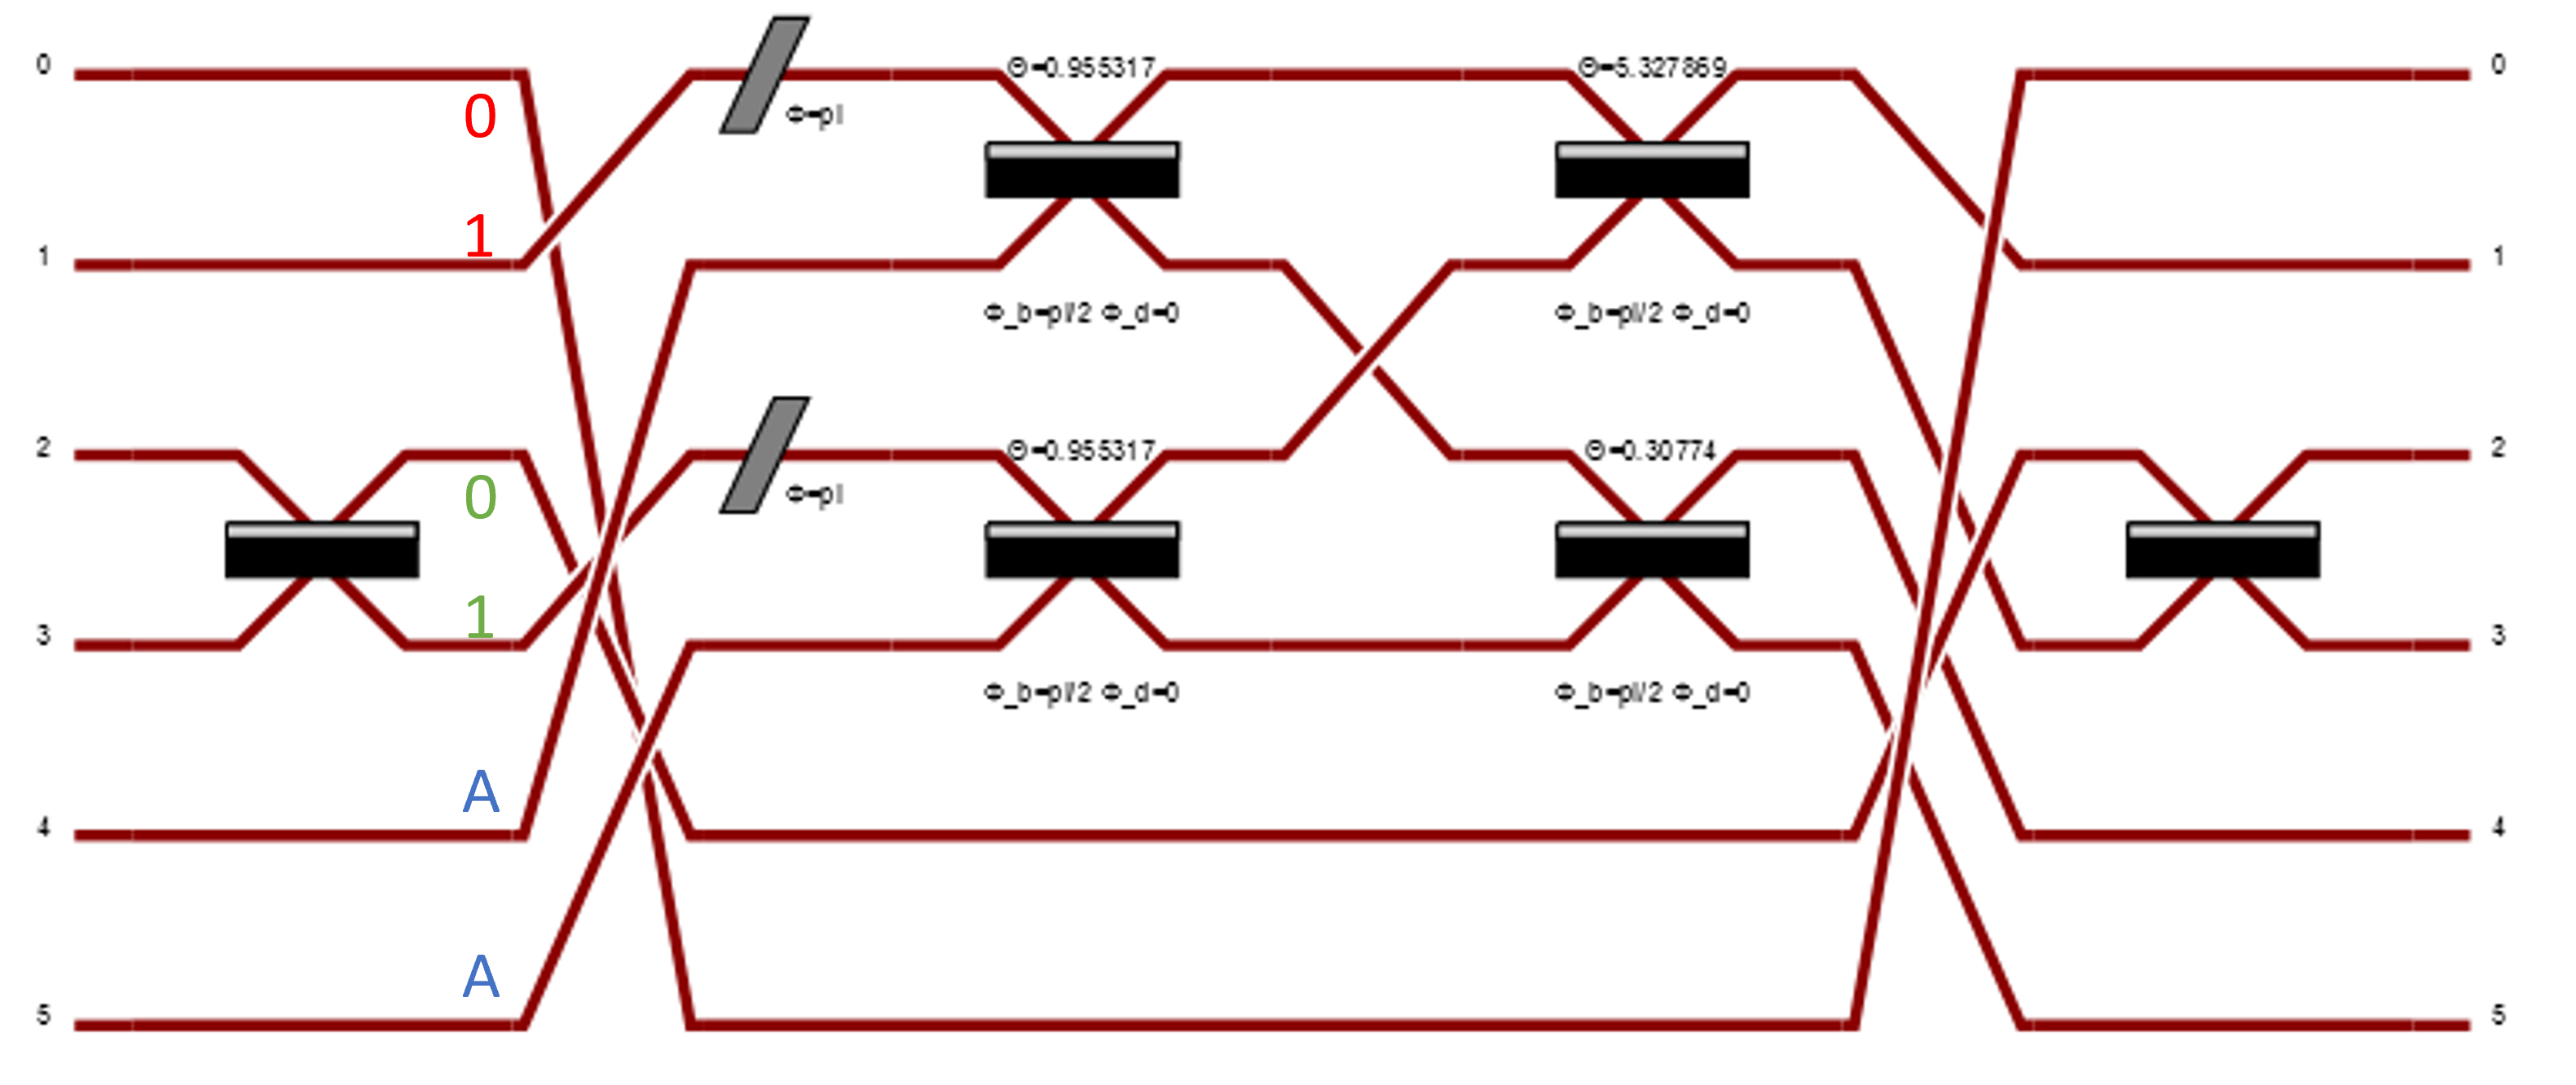

In [274]:
def klm_CX():
    circ = phys.Circuit(6, name="klm_CX")
    circ.add((2,3), phys.BS(R=1/2))
    circ.add((0,1,2,3,4,5), phys.PERM([5,0,4,2,1,3]))
    circ.add(0, KZ())
    circ.add((0,1,2,3,4,5), phys.PERM([1,3,4,5,2,0]))
    circ.add((2,3), phys.BS(R=1/2))
    return circ

In [675]:
circ=klm_CX()
pcvl.pdisplay(circ)

In [276]:
circ=klm_CX()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([1,0,1,0,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|4,0,0,0,0,0> 0.0
|3,1,0,0,0,0> 0.0
|3,0,1,0,0,0> 0.0
|3,0,0,1,0,0> 0.0
|3,0,0,0,1,0> 0.0
|3,0,0,0,0,1> 0.0
|2,2,0,0,0,0> 0.0
|2,1,1,0,0,0> 0.0
|2,1,0,1,0,0> 0.0
|2,1,0,0,1,0> 0.0
|2,1,0,0,0,1> 0.0
|2,0,2,0,0,0> 0.0
|2,0,1,1,0,0> 0.0
|2,0,1,0,1,0> 0.0
|2,0,1,0,0,1> 0.0
|2,0,0,2,0,0> 0.0
|2,0,0,1,1,0> 0.0
|2,0,0,1,0,1> 0.0
|2,0,0,0,2,0> 0.0
|2,0,0,0,1,1> 0.0
|2,0,0,0,0,2> 0.0
|1,3,0,0,0,0> 0.06584362139917695
|1,2,1,0,0,0> 0.049382716049382866
|1,2,0,1,0,0> 0.0493827160493825
|1,2,0,0,1,0> 0.04485176743031428
|1,2,0,0,0,1> 0.004530948619068493
|1,1,2,0,0,0> -3.469446951953614e-18
|1,1,1,1,0,0> 0.02469135802469141
|1,1,1,0,1,0> 0.0011327371547671383
|1,1,1,0,0,1> 0.011212941857578517
|1,1,0,2,0,0> 0.049382716049382956
|1,1,0,1,1,0> 0.06286113221649557
|1,1,0,1,0,1> 0.07294133691930693
|1,1,0,0,2,0> 0.0006235834224299027
|1,1,0,0,1,1> -3.848917712323541e-18
|1,1,0,0,0,2> 0.06110481163929842
|1,0,3,0,0,0> 0.016460905349794254
|1,0,2,1,0,0> 1.1837031692266463e-32
|1,0,2,0,1,0> 0.02695683233

In [277]:
circ=klm_CX()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([0,1,1,0,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|4,0,0,0,0,0> 0.0
|3,1,0,0,0,0> 0.0
|3,0,1,0,0,0> 0.0
|3,0,0,1,0,0> 0.0
|3,0,0,0,1,0> 0.0
|3,0,0,0,0,1> 0.0
|2,2,0,0,0,0> 0.0
|2,1,1,0,0,0> 0.0
|2,1,0,1,0,0> 0.0
|2,1,0,0,1,0> 0.0
|2,1,0,0,0,1> 0.0
|2,0,2,0,0,0> 0.0
|2,0,1,1,0,0> 0.0
|2,0,1,0,1,0> 0.0
|2,0,1,0,0,1> 0.0
|2,0,0,2,0,0> 0.0
|2,0,0,1,1,0> 0.0
|2,0,0,1,0,1> 0.0
|2,0,0,0,2,0> 0.0
|2,0,0,0,1,1> 0.0
|2,0,0,0,0,2> 0.0
|1,3,0,0,0,0> 0.0
|1,2,1,0,0,0> 0.0
|1,2,0,1,0,0> 0.0
|1,2,0,0,1,0> 0.0
|1,2,0,0,0,1> 0.0
|1,1,2,0,0,0> 0.0
|1,1,1,1,0,0> 0.0
|1,1,1,0,1,0> 0.0
|1,1,1,0,0,1> 0.0
|1,1,0,2,0,0> 0.0
|1,1,0,1,1,0> 0.0
|1,1,0,1,0,1> 0.0
|1,1,0,0,2,0> 0.0
|1,1,0,0,1,1> 0.0
|1,1,0,0,0,2> 0.0
|1,0,3,0,0,0> 0.0
|1,0,2,1,0,0> 0.0
|1,0,2,0,1,0> 0.0
|1,0,2,0,0,1> 0.0
|1,0,1,2,0,0> 0.0
|1,0,1,1,1,0> 0.0
|1,0,1,1,0,1> 0.0
|1,0,1,0,2,0> 0.0
|1,0,1,0,1,1> 0.0
|1,0,1,0,0,2> 0.0
|1,0,0,3,0,0> 0.0
|1,0,0,2,1,0> 0.0
|1,0,0,2,0,1> 0.0
|1,0,0,1,2,0> 0.0
|1,0,0,1,1,1> 0.0
|1,0,0,1,0,2> 0.0
|1,0,0,0,3,0> 0.0
|1,0,0,0,2,1> 0.0
|1,0,0,0,1,2> 0.0
|1,0,0,0,0

In [278]:
circ=klm_CX()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([0,1,0,1,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|4,0,0,0,0,0> 0.0
|3,1,0,0,0,0> 0.0
|3,0,1,0,0,0> 0.0
|3,0,0,1,0,0> 0.0
|3,0,0,0,1,0> 0.0
|3,0,0,0,0,1> 0.0
|2,2,0,0,0,0> 0.0
|2,1,1,0,0,0> 0.0
|2,1,0,1,0,0> 0.0
|2,1,0,0,1,0> 0.0
|2,1,0,0,0,1> 0.0
|2,0,2,0,0,0> 0.0
|2,0,1,1,0,0> 0.0
|2,0,1,0,1,0> 0.0
|2,0,1,0,0,1> 0.0
|2,0,0,2,0,0> 0.0
|2,0,0,1,1,0> 0.0
|2,0,0,1,0,1> 0.0
|2,0,0,0,2,0> 0.0
|2,0,0,0,1,1> 0.0
|2,0,0,0,0,2> 0.0
|1,3,0,0,0,0> 0.0
|1,2,1,0,0,0> 0.0
|1,2,0,1,0,0> 0.0
|1,2,0,0,1,0> 0.0
|1,2,0,0,0,1> 0.0
|1,1,2,0,0,0> 0.0
|1,1,1,1,0,0> 0.0
|1,1,1,0,1,0> 0.0
|1,1,1,0,0,1> 0.0
|1,1,0,2,0,0> 0.0
|1,1,0,1,1,0> 0.0
|1,1,0,1,0,1> 0.0
|1,1,0,0,2,0> 0.0
|1,1,0,0,1,1> 0.0
|1,1,0,0,0,2> 0.0
|1,0,3,0,0,0> 0.0
|1,0,2,1,0,0> 0.0
|1,0,2,0,1,0> 0.0
|1,0,2,0,0,1> 0.0
|1,0,1,2,0,0> 0.0
|1,0,1,1,1,0> 0.0
|1,0,1,1,0,1> 0.0
|1,0,1,0,2,0> 0.0
|1,0,1,0,1,1> 0.0
|1,0,1,0,0,2> 0.0
|1,0,0,3,0,0> 0.0
|1,0,0,2,1,0> 0.0
|1,0,0,2,0,1> 0.0
|1,0,0,1,2,0> 0.0
|1,0,0,1,1,1> 0.0
|1,0,0,1,0,2> 0.0
|1,0,0,0,3,0> 0.0
|1,0,0,0,2,1> 0.0
|1,0,0,0,1,2> 0.0
|1,0,0,0,0

In [280]:
circ=klm_CX()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([1,0,1,0,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|4,0,0,0,0,0> 0.0
|3,1,0,0,0,0> 0.0
|3,0,1,0,0,0> 0.0
|3,0,0,1,0,0> 0.0
|3,0,0,0,1,0> 0.0
|3,0,0,0,0,1> 0.0
|2,2,0,0,0,0> 0.0
|2,1,1,0,0,0> 0.0
|2,1,0,1,0,0> 0.0
|2,1,0,0,1,0> 0.0
|2,1,0,0,0,1> 0.0
|2,0,2,0,0,0> 0.0
|2,0,1,1,0,0> 0.0
|2,0,1,0,1,0> 0.0
|2,0,1,0,0,1> 0.0
|2,0,0,2,0,0> 0.0
|2,0,0,1,1,0> 0.0
|2,0,0,1,0,1> 0.0
|2,0,0,0,2,0> 0.0
|2,0,0,0,1,1> 0.0
|2,0,0,0,0,2> 0.0
|1,3,0,0,0,0> 0.06584362139917695
|1,2,1,0,0,0> 0.049382716049382866
|1,2,0,1,0,0> 0.0493827160493825
|1,2,0,0,1,0> 0.04485176743031428
|1,2,0,0,0,1> 0.004530948619068493
|1,1,2,0,0,0> -3.469446951953614e-18
|1,1,1,1,0,0> 0.02469135802469141
|1,1,1,0,1,0> 0.0011327371547671383
|1,1,1,0,0,1> 0.011212941857578517
|1,1,0,2,0,0> 0.049382716049382956
|1,1,0,1,1,0> 0.06286113221649557
|1,1,0,1,0,1> 0.07294133691930693
|1,1,0,0,2,0> 0.0006235834224299027
|1,1,0,0,1,1> -3.848917712323541e-18
|1,1,0,0,0,2> 0.06110481163929842
|1,0,3,0,0,0> 0.016460905349794254
|1,0,2,1,0,0> 1.1837031692266463e-32
|1,0,2,0,1,0> 0.02695683233

### Second gate: the CCCZ gate

The CCCZ gate is the gate that applies a global $\pi$ phase whenever the four qubits are in the state $1$. This corresponds to the case when the two qu-4-its are in the state $11$. Consequently, the corresponding modes are introduced into the knill CZ.

The gate takes the following shape:

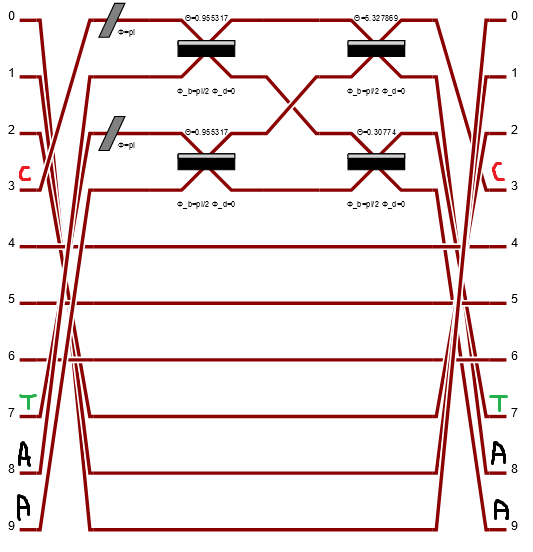

The probability of success of the gate is: $\frac{2}{27}$.

In [281]:
def CCCZ():
    circ = phys.Circuit(10, name="CCCZ")
    circ.add((0,1,2,3,4,5,6,7,8,9), phys.PERM([9,8,7,0,4,5,6,2,1,3]))
    circ.add(0, KZ())
    circ.add((0,1,2,3,4,5,6,7,8,9), phys.PERM([3,7,8,9,4,5,6,2,1,0]))
    return circ

In [676]:
circ=CCCZ()
pcvl.pdisplay(circ)

In [283]:
circ=CCCZ()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([0,0,0,1,0,0,0,1,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|4,0,0,0,0,0,0,0,0,0> 0.0
|3,1,0,0,0,0,0,0,0,0> 0.0
|3,0,1,0,0,0,0,0,0,0> 0.0
|3,0,0,1,0,0,0,0,0,0> 0.0
|3,0,0,0,1,0,0,0,0,0> 0.0
|3,0,0,0,0,1,0,0,0,0> 0.0
|3,0,0,0,0,0,1,0,0,0> 0.0
|3,0,0,0,0,0,0,1,0,0> 0.0
|3,0,0,0,0,0,0,0,1,0> 0.0
|3,0,0,0,0,0,0,0,0,1> 0.0
|2,2,0,0,0,0,0,0,0,0> 0.0
|2,1,1,0,0,0,0,0,0,0> 0.0
|2,1,0,1,0,0,0,0,0,0> 0.0
|2,1,0,0,1,0,0,0,0,0> 0.0
|2,1,0,0,0,1,0,0,0,0> 0.0
|2,1,0,0,0,0,1,0,0,0> 0.0
|2,1,0,0,0,0,0,1,0,0> 0.0
|2,1,0,0,0,0,0,0,1,0> 0.0
|2,1,0,0,0,0,0,0,0,1> 0.0
|2,0,2,0,0,0,0,0,0,0> 0.0
|2,0,1,1,0,0,0,0,0,0> 0.0
|2,0,1,0,1,0,0,0,0,0> 0.0
|2,0,1,0,0,1,0,0,0,0> 0.0
|2,0,1,0,0,0,1,0,0,0> 0.0
|2,0,1,0,0,0,0,1,0,0> 0.0
|2,0,1,0,0,0,0,0,1,0> 0.0
|2,0,1,0,0,0,0,0,0,1> 0.0
|2,0,0,2,0,0,0,0,0,0> 0.0
|2,0,0,1,1,0,0,0,0,0> 0.0
|2,0,0,1,0,1,0,0,0,0> 0.0
|2,0,0,1,0,0,1,0,0,0> 0.0
|2,0,0,1,0,0,0,1,0,0> 0.0
|2,0,0,1,0,0,0,0,1,0> 0.0
|2,0,0,1,0,0,0,0,0,1> 0.0
|2,0,0,0,2,0,0,0,0,0> 0.0
|2,0,0,0,1,1,0,0,0,0> 0.0
|2,0,0,0,1,0,1,0,0,0> 0.0
|2,0,0,0,1,0,0,1,0,0> 0.0
|2,0,0,0,1,0

In [284]:
circ=CCCZ()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([0,1,0,0,0,0,0,1,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|4,0,0,0,0,0,0,0,0,0> 0.0
|3,1,0,0,0,0,0,0,0,0> 0.0
|3,0,1,0,0,0,0,0,0,0> 0.0
|3,0,0,1,0,0,0,0,0,0> 0.0
|3,0,0,0,1,0,0,0,0,0> 0.0
|3,0,0,0,0,1,0,0,0,0> 0.0
|3,0,0,0,0,0,1,0,0,0> 0.0
|3,0,0,0,0,0,0,1,0,0> 0.0
|3,0,0,0,0,0,0,0,1,0> 0.0
|3,0,0,0,0,0,0,0,0,1> 0.0
|2,2,0,0,0,0,0,0,0,0> 0.0
|2,1,1,0,0,0,0,0,0,0> 0.0
|2,1,0,1,0,0,0,0,0,0> 0.0
|2,1,0,0,1,0,0,0,0,0> 0.0
|2,1,0,0,0,1,0,0,0,0> 0.0
|2,1,0,0,0,0,1,0,0,0> 0.0
|2,1,0,0,0,0,0,1,0,0> 0.0
|2,1,0,0,0,0,0,0,1,0> 0.0
|2,1,0,0,0,0,0,0,0,1> 0.0
|2,0,2,0,0,0,0,0,0,0> 0.0
|2,0,1,1,0,0,0,0,0,0> 0.0
|2,0,1,0,1,0,0,0,0,0> 0.0
|2,0,1,0,0,1,0,0,0,0> 0.0
|2,0,1,0,0,0,1,0,0,0> 0.0
|2,0,1,0,0,0,0,1,0,0> 0.0
|2,0,1,0,0,0,0,0,1,0> 0.0
|2,0,1,0,0,0,0,0,0,1> 0.0
|2,0,0,2,0,0,0,0,0,0> 0.0
|2,0,0,1,1,0,0,0,0,0> 0.0
|2,0,0,1,0,1,0,0,0,0> 0.0
|2,0,0,1,0,0,1,0,0,0> 0.0
|2,0,0,1,0,0,0,1,0,0> 0.0
|2,0,0,1,0,0,0,0,1,0> 0.0
|2,0,0,1,0,0,0,0,0,1> 0.0
|2,0,0,0,2,0,0,0,0,0> 0.0
|2,0,0,0,1,1,0,0,0,0> 0.0
|2,0,0,0,1,0,1,0,0,0> 0.0
|2,0,0,0,1,0,0,1,0,0> 0.0
|2,0,0,0,1,0

### Third gate: the CCCX gate

As explained previously, the CCCX gate can be obtained by applying a basis transformation in both sides of the CCCZ gate. This basis change is of course the Hadamard gate. However, we need not apply the Hadamard gate on the second qubit of the second qu-4-it. Instead, we only apply beam splitter on the last two modes of the second qu-4-it.  The reason behind this choice is that the CCCZ gate is only applied iff the input photon is in mode $7$. However, we would obtain the same result if we added bean splitters between the modes $4$ and $5$.

In [285]:
def CCCX():
    circ = phys.Circuit(10, name="CCCX")
    circ.add((6, 7), phys.BS(R=1/2))
    circ.add(0, CCCZ())
    circ.add((6, 7), phys.BS(R=1/2))
    return circ

In [678]:
circ=CCCX()
pcvl.pdisplay(circ, recursive=True)

### Fourth gate: Hybrid CCX 1

This gate is our first hybrid gate. The control qubits are represented by a qu-4-it; whereas the target qubit is represented by a dual rail. The modes $3$ and $5$ are introduced into the knill CZ because they correspond to the state $111$.

Here again, we use the Hadamard basis transformation.

The circuit takes the followng shape:

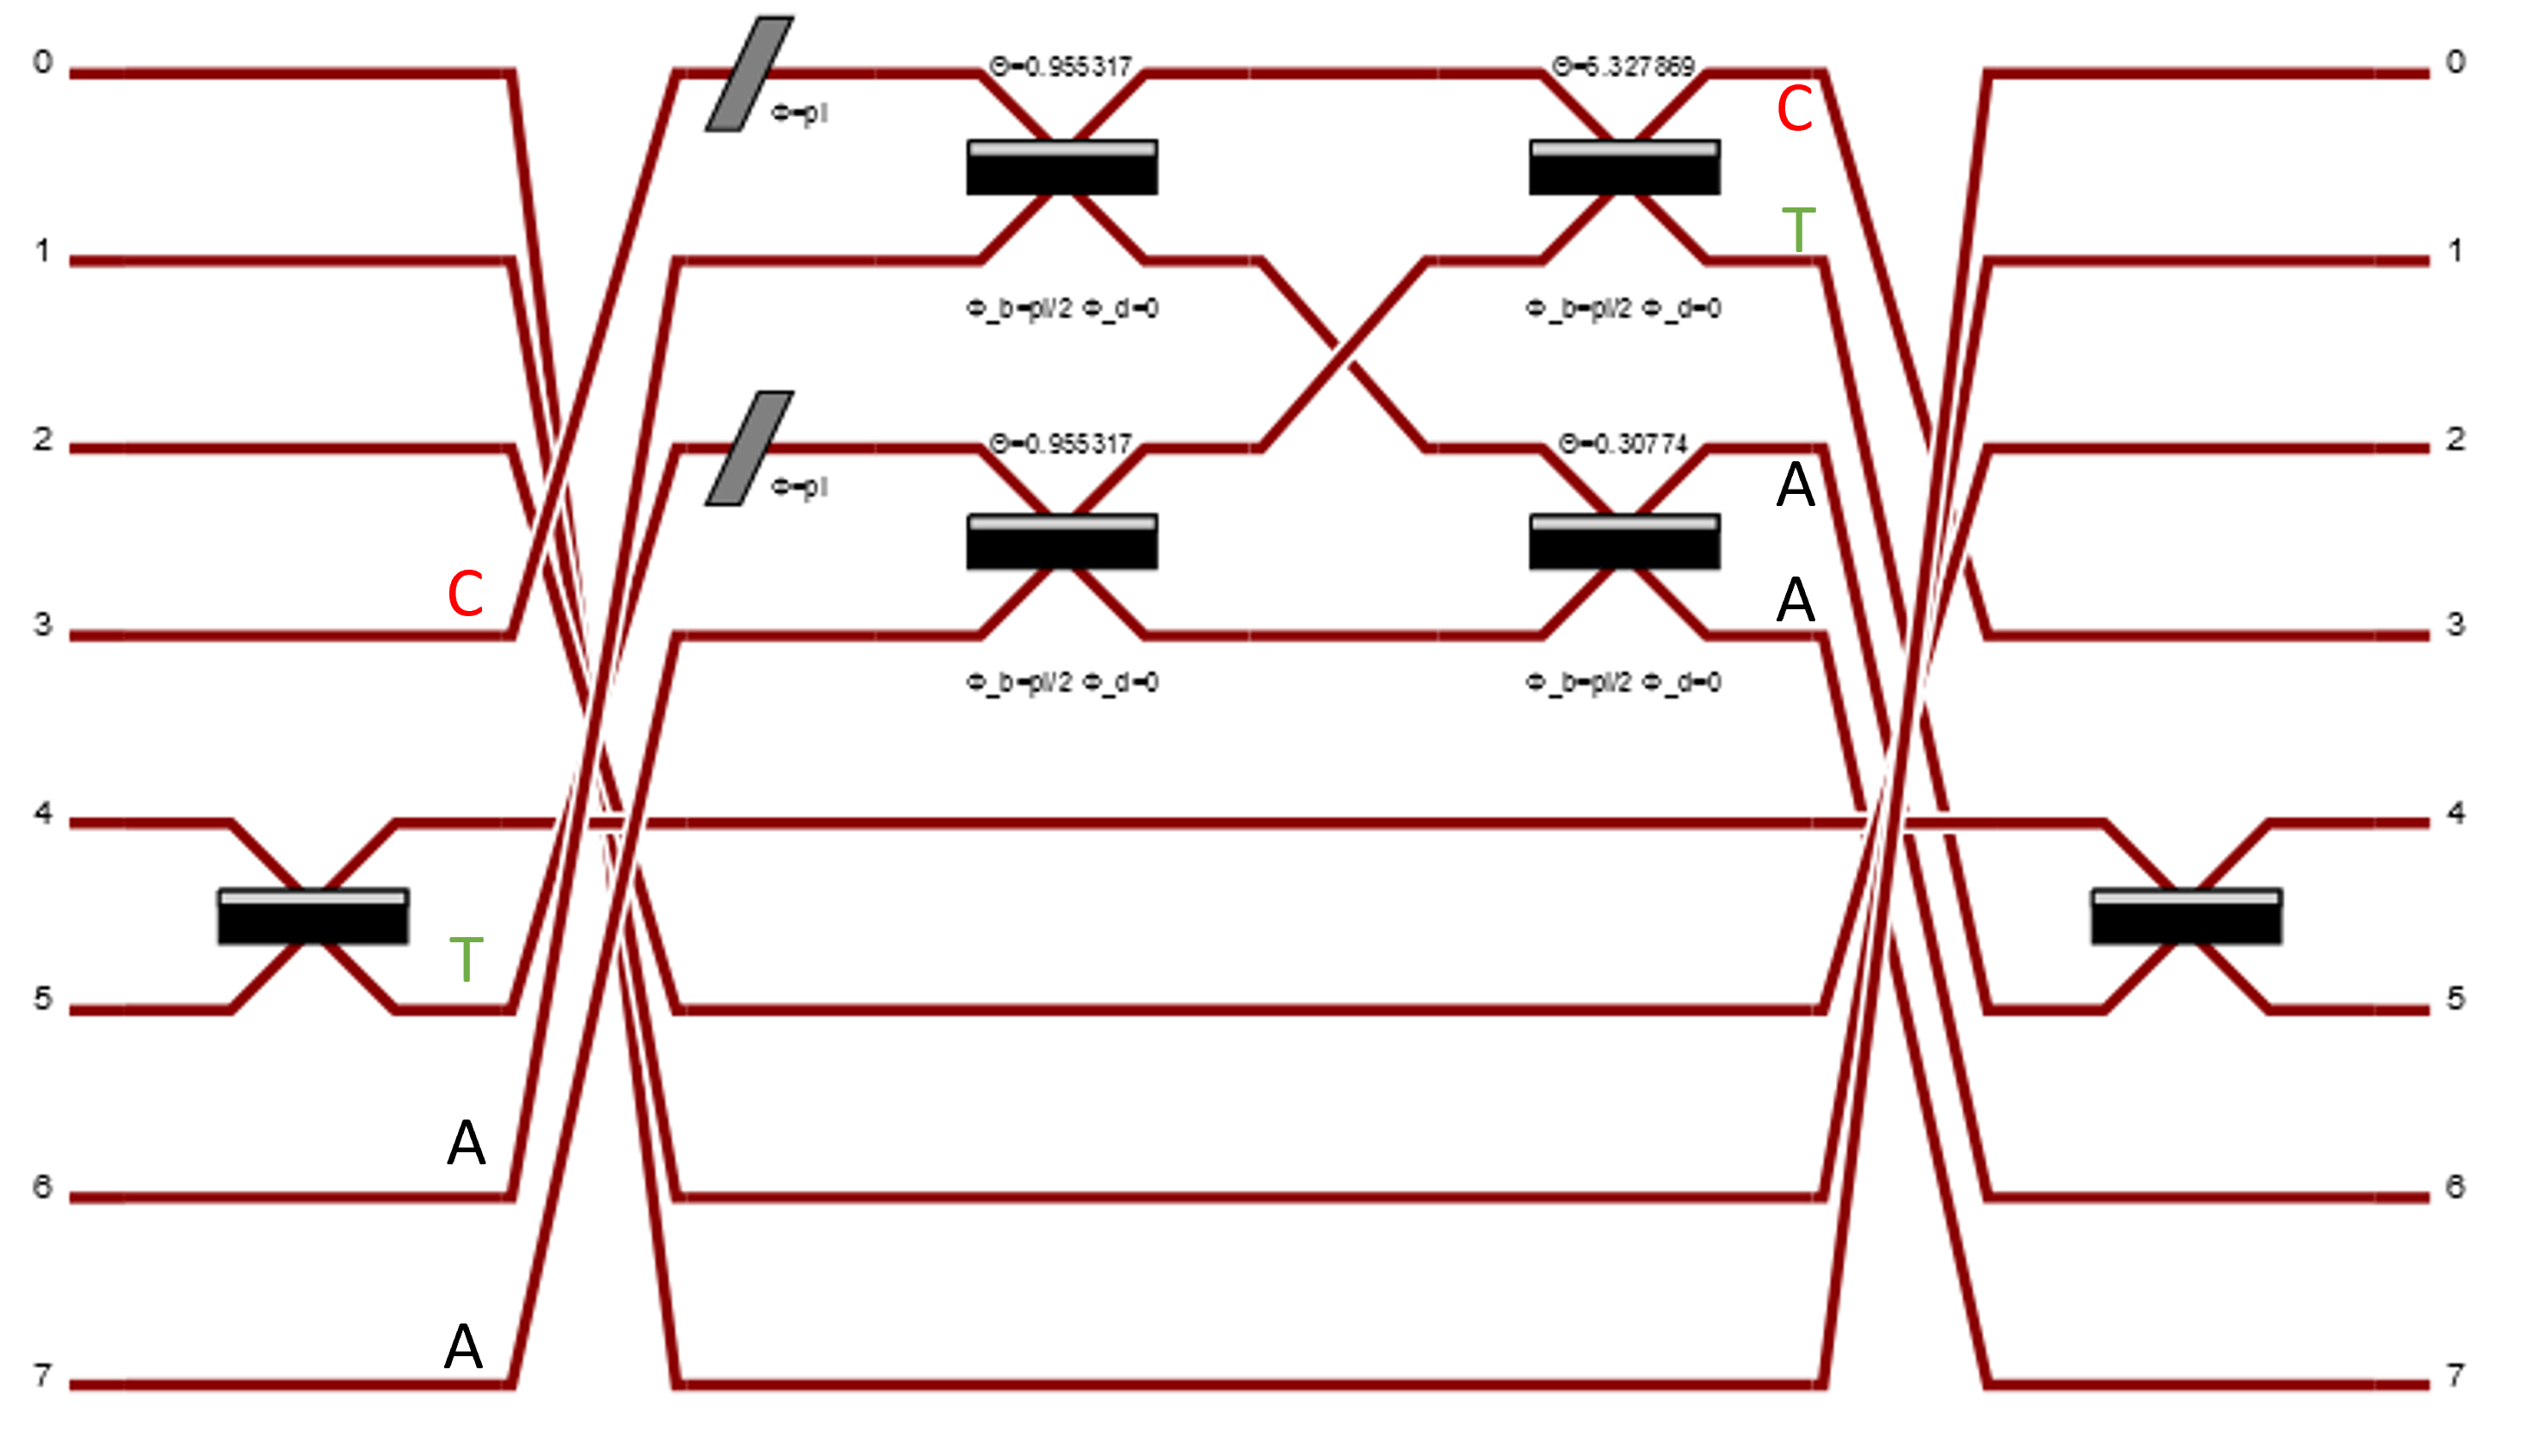


The probability of success of the gate is: $\frac{2}{27}$.

In [287]:
def CCX():
    circ = phys.Circuit(8, name="CCX")
    circ.add((4, 5), phys.BS(R=1/2))
    circ.add((0,1,2,3,4,5,6,7), phys.PERM([7,6,5,0,4,2,1,3]))
    circ.add(0, KZ())
    circ.add((0,1,2,3,4,5,6,7), phys.PERM([3,5,6,7,4,2,1,0]))
    circ.add((4, 5), phys.BS(R=1/2))
    return circ

In [679]:
circ=CCX()
pcvl.pdisplay(circ)

In [289]:
circ=CCX()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([0,0,0,1,0,1,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|4,0,0,0,0,0,0,0> 0.0
|3,1,0,0,0,0,0,0> 0.0
|3,0,1,0,0,0,0,0> 0.0
|3,0,0,1,0,0,0,0> 0.0
|3,0,0,0,1,0,0,0> 0.0
|3,0,0,0,0,1,0,0> 0.0
|3,0,0,0,0,0,1,0> 0.0
|3,0,0,0,0,0,0,1> 0.0
|2,2,0,0,0,0,0,0> 0.0
|2,1,1,0,0,0,0,0> 0.0
|2,1,0,1,0,0,0,0> 0.0
|2,1,0,0,1,0,0,0> 0.0
|2,1,0,0,0,1,0,0> 0.0
|2,1,0,0,0,0,1,0> 0.0
|2,1,0,0,0,0,0,1> 0.0
|2,0,2,0,0,0,0,0> 0.0
|2,0,1,1,0,0,0,0> 0.0
|2,0,1,0,1,0,0,0> 0.0
|2,0,1,0,0,1,0,0> 0.0
|2,0,1,0,0,0,1,0> 0.0
|2,0,1,0,0,0,0,1> 0.0
|2,0,0,2,0,0,0,0> 0.0
|2,0,0,1,1,0,0,0> 0.0
|2,0,0,1,0,1,0,0> 0.0
|2,0,0,1,0,0,1,0> 0.0
|2,0,0,1,0,0,0,1> 0.0
|2,0,0,0,2,0,0,0> 0.0
|2,0,0,0,1,1,0,0> 0.0
|2,0,0,0,1,0,1,0> 0.0
|2,0,0,0,1,0,0,1> 0.0
|2,0,0,0,0,2,0,0> 0.0
|2,0,0,0,0,1,1,0> 0.0
|2,0,0,0,0,1,0,1> 0.0
|2,0,0,0,0,0,2,0> 0.0
|2,0,0,0,0,0,1,1> 0.0
|2,0,0,0,0,0,0,2> 0.0
|1,3,0,0,0,0,0,0> 0.0
|1,2,1,0,0,0,0,0> 0.0
|1,2,0,1,0,0,0,0> 0.0
|1,2,0,0,1,0,0,0> 0.0
|1,2,0,0,0,1,0,0> 0.0
|1,2,0,0,0,0,1,0> 0.0
|1,2,0,0,0,0,0,1> 0.0
|1,1,2,0,0,0,0,0> 0.0
|1,1,1,1,0,0,0,0> 0.0
|1,1,1,0,1

In [290]:
circ=CCX()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([0,0,1,0,0,1,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|4,0,0,0,0,0,0,0> 0.0
|3,1,0,0,0,0,0,0> 0.0
|3,0,1,0,0,0,0,0> 0.0
|3,0,0,1,0,0,0,0> 0.0
|3,0,0,0,1,0,0,0> 0.0
|3,0,0,0,0,1,0,0> 0.0
|3,0,0,0,0,0,1,0> 0.0
|3,0,0,0,0,0,0,1> 0.0
|2,2,0,0,0,0,0,0> 0.0
|2,1,1,0,0,0,0,0> 0.0
|2,1,0,1,0,0,0,0> 0.0
|2,1,0,0,1,0,0,0> 0.0
|2,1,0,0,0,1,0,0> 0.0
|2,1,0,0,0,0,1,0> 0.0
|2,1,0,0,0,0,0,1> 0.0
|2,0,2,0,0,0,0,0> 0.0
|2,0,1,1,0,0,0,0> 0.0
|2,0,1,0,1,0,0,0> 0.0
|2,0,1,0,0,1,0,0> 0.0
|2,0,1,0,0,0,1,0> 0.0
|2,0,1,0,0,0,0,1> 0.0
|2,0,0,2,0,0,0,0> 0.0
|2,0,0,1,1,0,0,0> 0.0
|2,0,0,1,0,1,0,0> 0.0
|2,0,0,1,0,0,1,0> 0.0
|2,0,0,1,0,0,0,1> 0.0
|2,0,0,0,2,0,0,0> 0.0
|2,0,0,0,1,1,0,0> 0.0
|2,0,0,0,1,0,1,0> 0.0
|2,0,0,0,1,0,0,1> 0.0
|2,0,0,0,0,2,0,0> 0.0
|2,0,0,0,0,1,1,0> 0.0
|2,0,0,0,0,1,0,1> 0.0
|2,0,0,0,0,0,2,0> 0.0
|2,0,0,0,0,0,1,1> 0.0
|2,0,0,0,0,0,0,2> 0.0
|1,3,0,0,0,0,0,0> 0.0
|1,2,1,0,0,0,0,0> 0.0
|1,2,0,1,0,0,0,0> 0.0
|1,2,0,0,1,0,0,0> 0.0
|1,2,0,0,0,1,0,0> 0.0
|1,2,0,0,0,0,1,0> 0.0
|1,2,0,0,0,0,0,1> 0.0
|1,1,2,0,0,0,0,0> 0.0
|1,1,1,1,0,0,0,0> 0.0
|1,1,1,0,1

### Sixth gate: CCZ

The definition of this gate relies on the following identity:

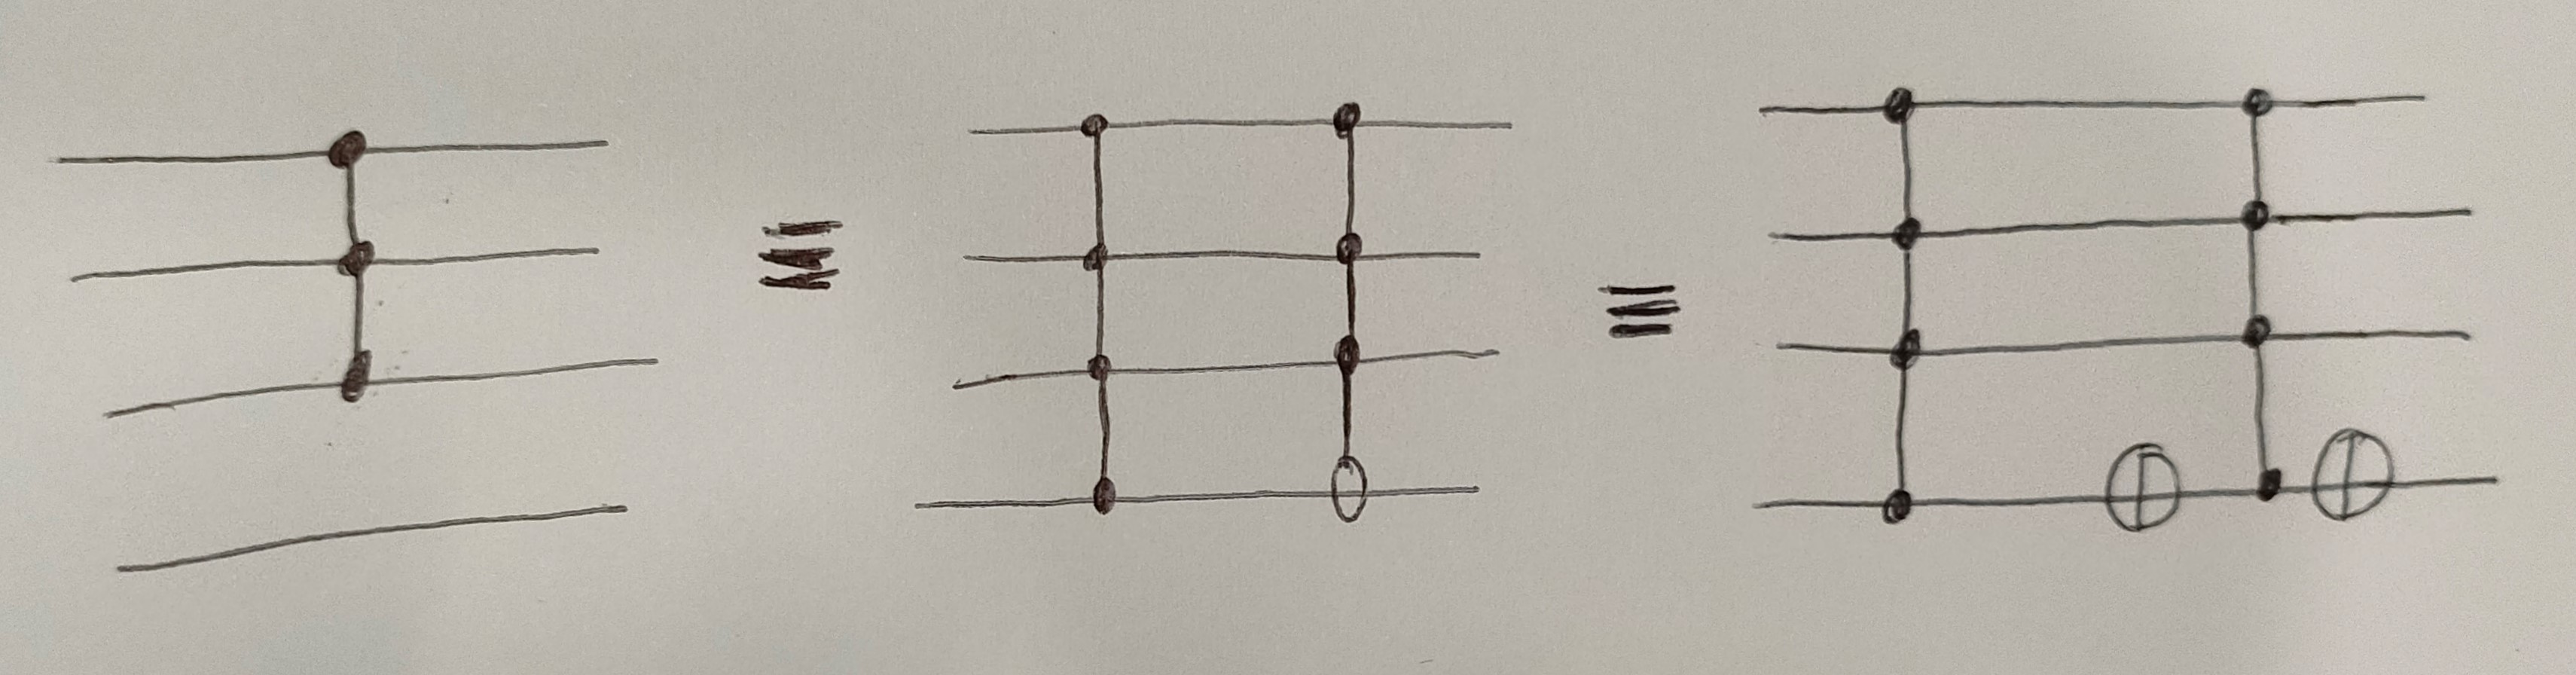

Since the CCZ gate uses two CCCZ gates, its success probability is: $\left(\frac{2}{27}\right)^2 \approx 0.005486968$.

We chose to eliminate the last qubit. Consequently, we are implementing a CCZ on the three first qubits.

In [421]:
def CCZ():
    circ=pcvl.Circuit(12,name="CCZ")
    circ.add(0,CCCZ())
    circ.add(4, NOT1())
    circ.add((0,1,2,3,4,5,6,7,8,9,10,11), phys.PERM([0,1,2,3,4,5,6,7,10,11,8,9])) # change ancillas
    circ.add(0,CCCZ())
    circ.add(4, NOT1())
    return circ

In [680]:
circ=CCZ()
pcvl.pdisplay(circ, recursive=True)

In [424]:
circ=CCZ()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([0,0,0,1,0,0,0,1,1,1,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|6,0,0,0,0,0,0,0,0,0,0,0> 0.0
|5,1,0,0,0,0,0,0,0,0,0,0> 0.0
|5,0,1,0,0,0,0,0,0,0,0,0> 0.0
|5,0,0,1,0,0,0,0,0,0,0,0> 0.0
|5,0,0,0,1,0,0,0,0,0,0,0> 0.0
|5,0,0,0,0,1,0,0,0,0,0,0> 0.0
|5,0,0,0,0,0,1,0,0,0,0,0> 0.0
|5,0,0,0,0,0,0,1,0,0,0,0> 0.0
|5,0,0,0,0,0,0,0,1,0,0,0> 0.0
|5,0,0,0,0,0,0,0,0,1,0,0> 0.0
|5,0,0,0,0,0,0,0,0,0,1,0> 0.0
|5,0,0,0,0,0,0,0,0,0,0,1> 0.0
|4,2,0,0,0,0,0,0,0,0,0,0> 0.0
|4,1,1,0,0,0,0,0,0,0,0,0> 0.0
|4,1,0,1,0,0,0,0,0,0,0,0> 0.0
|4,1,0,0,1,0,0,0,0,0,0,0> 0.0
|4,1,0,0,0,1,0,0,0,0,0,0> 0.0
|4,1,0,0,0,0,1,0,0,0,0,0> 0.0
|4,1,0,0,0,0,0,1,0,0,0,0> 0.0
|4,1,0,0,0,0,0,0,1,0,0,0> 0.0
|4,1,0,0,0,0,0,0,0,1,0,0> 0.0
|4,1,0,0,0,0,0,0,0,0,1,0> 0.0
|4,1,0,0,0,0,0,0,0,0,0,1> 0.0
|4,0,2,0,0,0,0,0,0,0,0,0> 0.0
|4,0,1,1,0,0,0,0,0,0,0,0> 0.0
|4,0,1,0,1,0,0,0,0,0,0,0> 0.0
|4,0,1,0,0,1,0,0,0,0,0,0> 0.0
|4,0,1,0,0,0,1,0,0,0,0,0> 0.0
|4,0,1,0,0,0,0,1,0,0,0,0> 0.0
|4,0,1,0,0,0,0,0,1,0,0,0> 0.0
|4,0,1,0,0,0,0,0,0,1,0,0> 0.0
|4,0,1,0,0,0,0,0,0,0,1,0> 0.0
|4,0,1,0,0,0,0,0,0,0,0,1> 0.0
|4,0,0,2,0

### Seventh gate: qudit CCX

Similarly, we use the same trick as the one used for CCZ. Consequently, the success probability is: $\left(\frac{2}{27}\right)^2$. However, the CCZ gate is between two Hadamards applied to the first qubit of the second qu-4-it.

In [428]:
def qudit_CCX():
    circ = phys.Circuit(12, name="CCX")
    circ.add(4, H0())
    circ.add(0, CCZ())
    circ.add(4, H0())
    return circ

In [682]:
circ=qudit_CCX()
pcvl.pdisplay(circ,recursive=True)

In [431]:
circ=qudit_CCX()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_klm=pcvl.BasicState([0,0,0,1,0,0,0,1,1,1,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_klm):
    print(state, complex(prob).real)

|6,0,0,0,0,0,0,0,0,0,0,0> 0.0
|5,1,0,0,0,0,0,0,0,0,0,0> 0.0
|5,0,1,0,0,0,0,0,0,0,0,0> 0.0
|5,0,0,1,0,0,0,0,0,0,0,0> 0.0
|5,0,0,0,1,0,0,0,0,0,0,0> 0.0
|5,0,0,0,0,1,0,0,0,0,0,0> 0.0
|5,0,0,0,0,0,1,0,0,0,0,0> 0.0
|5,0,0,0,0,0,0,1,0,0,0,0> 0.0
|5,0,0,0,0,0,0,0,1,0,0,0> 0.0
|5,0,0,0,0,0,0,0,0,1,0,0> 0.0
|5,0,0,0,0,0,0,0,0,0,1,0> 0.0
|5,0,0,0,0,0,0,0,0,0,0,1> 0.0
|4,2,0,0,0,0,0,0,0,0,0,0> 0.0
|4,1,1,0,0,0,0,0,0,0,0,0> 0.0
|4,1,0,1,0,0,0,0,0,0,0,0> 0.0
|4,1,0,0,1,0,0,0,0,0,0,0> 0.0
|4,1,0,0,0,1,0,0,0,0,0,0> 0.0
|4,1,0,0,0,0,1,0,0,0,0,0> 0.0
|4,1,0,0,0,0,0,1,0,0,0,0> 0.0
|4,1,0,0,0,0,0,0,1,0,0,0> 0.0
|4,1,0,0,0,0,0,0,0,1,0,0> 0.0
|4,1,0,0,0,0,0,0,0,0,1,0> 0.0
|4,1,0,0,0,0,0,0,0,0,0,1> 0.0
|4,0,2,0,0,0,0,0,0,0,0,0> 0.0
|4,0,1,1,0,0,0,0,0,0,0,0> 0.0
|4,0,1,0,1,0,0,0,0,0,0,0> 0.0
|4,0,1,0,0,1,0,0,0,0,0,0> 0.0
|4,0,1,0,0,0,1,0,0,0,0,0> 0.0
|4,0,1,0,0,0,0,1,0,0,0,0> 0.0
|4,0,1,0,0,0,0,0,1,0,0,0> 0.0
|4,0,1,0,0,0,0,0,0,1,0,0> 0.0
|4,0,1,0,0,0,0,0,0,0,1,0> 0.0
|4,0,1,0,0,0,0,0,0,0,0,1> 0.0
|4,0,0,2,0

### Eighth gate: cross-qudit CNOT

We introduce NOT gates in order to express the CX in terms of CCX. We get the following:

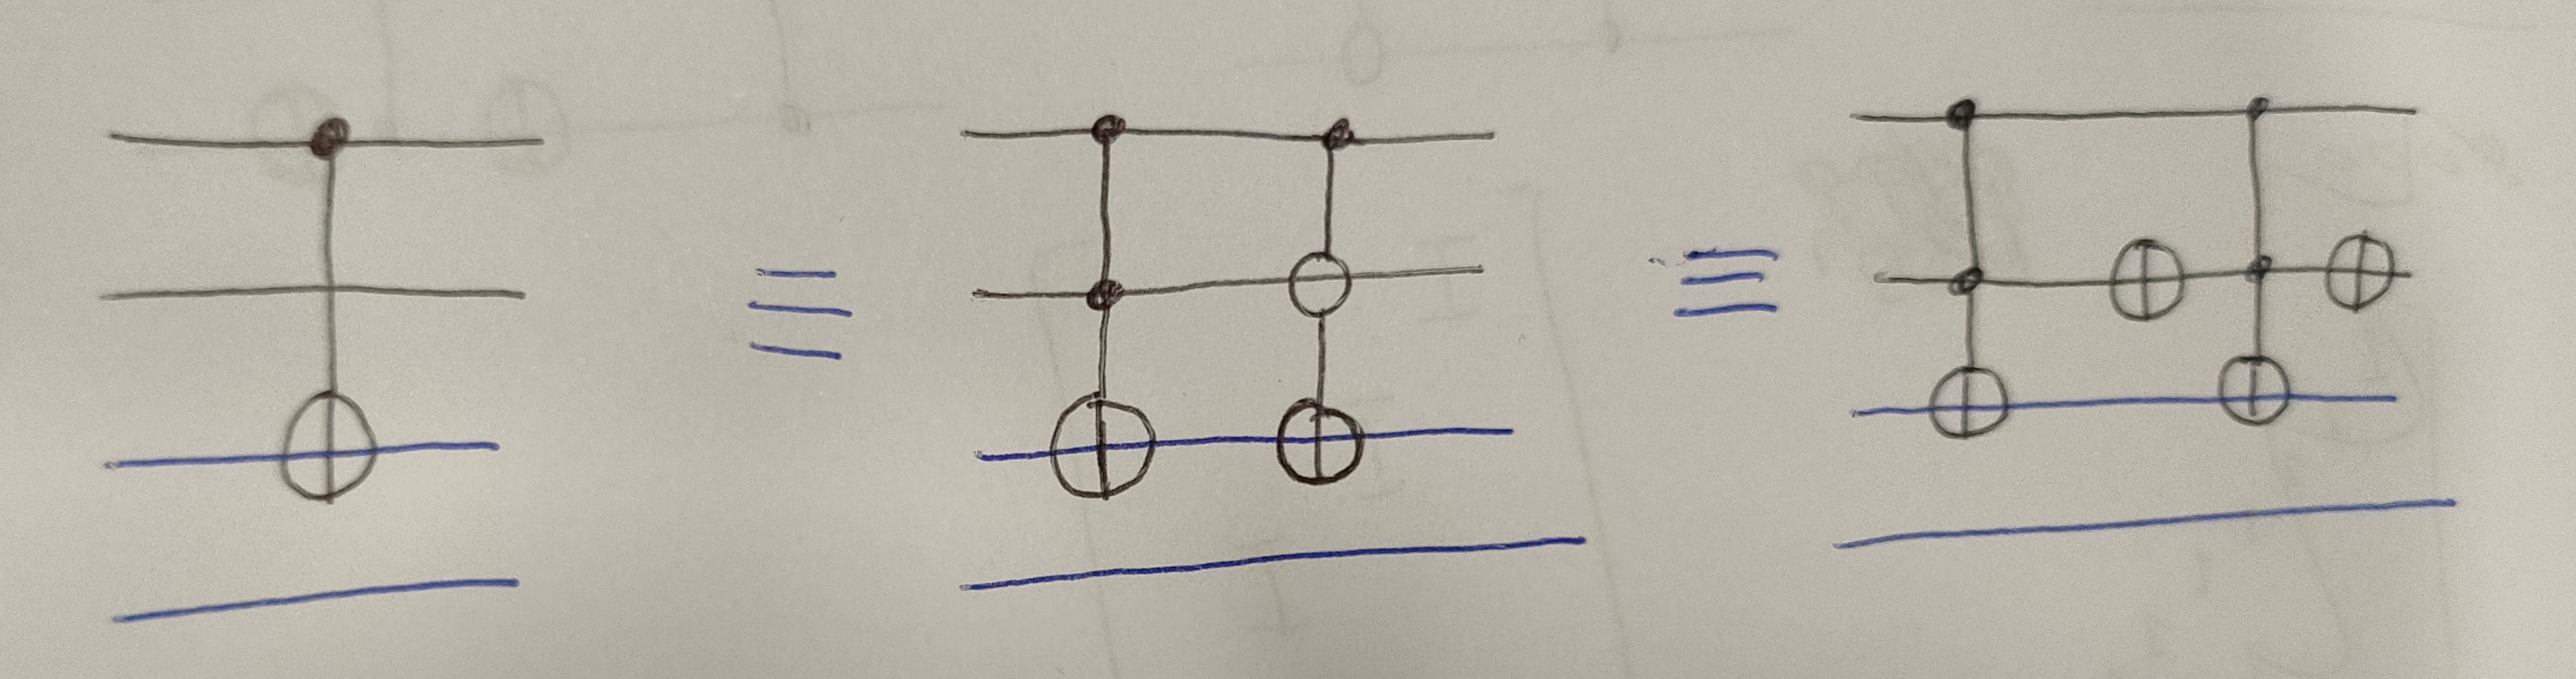

Since the gate uses $2$ CCX, the probability of success is: $\left(\frac{2}{27}\right)^4 \approx 3.010682277 \times 10^{-5}$.

In [432]:
def inter_CX():
    circ=qudit_CCX()
    circ.add(0,NOT1())
    circ.add(0, qudit_CCX())
    circ.add(0,NOT1())
    return circ

In [684]:
circ=inter_CX()
pcvl.pdisplay(circ,recursive=True)

### Ninth gate: CCSWAP

The CCSWAP relies on a clever swap of modes before and after the CCCX gate. In particular, it relies on the following observations.

1. A SWAP acting on a qu-4-it can be expressed in terms of a CNOT and mode permutations.
2. CCCX is a doubly-conditioned CNOT.

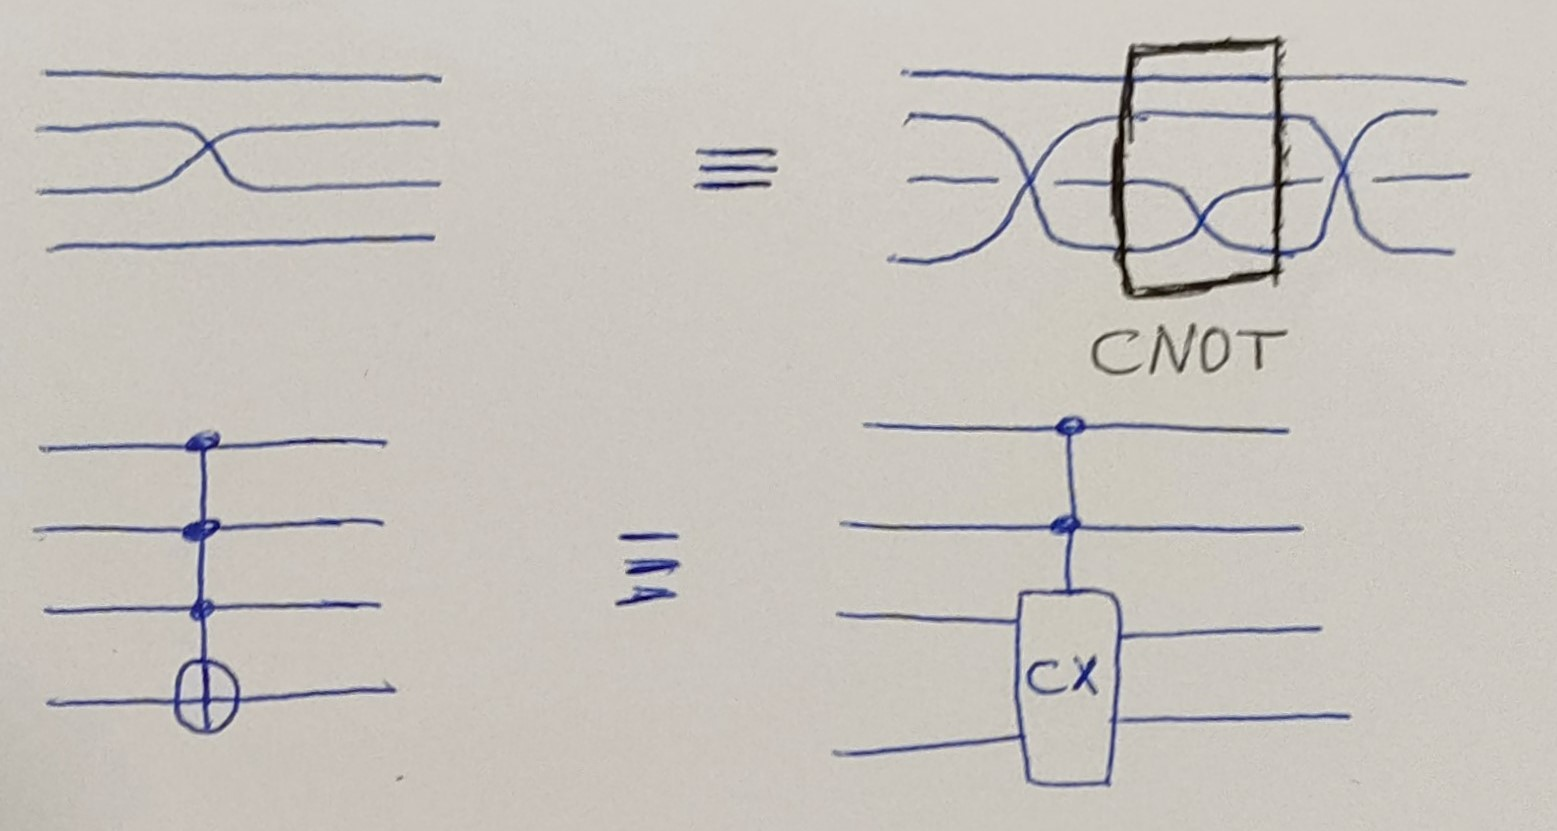

Because we use one knill CZ, the probability of success is: $\frac{2}{27}$.

In [313]:
def CCSWAP():
    circ=pcvl.Circuit(10,name="CCSWAP")
    circ.add((0,1,2,3,4,5,6,7,8,9),phys.PERM([0,1,2,3,4,7,6,5,8,9]))
    circ.add(0, CCCX())
    circ.add((0,1,2,3,4,5,6,7,8,9),phys.PERM([0,1,2,3,4,7,6,5,8,9]))
    return circ

In [685]:
circ=CCSWAP()
pcvl.pdisplay(circ,recursive=True)

In [315]:
circ=CCSWAP()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_test=pcvl.BasicState([0,0,0,1,0,0,1,0,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_test):
    print(state, complex(prob).real)

|4,0,0,0,0,0,0,0,0,0> 0.0
|3,1,0,0,0,0,0,0,0,0> 0.0
|3,0,1,0,0,0,0,0,0,0> 0.0
|3,0,0,1,0,0,0,0,0,0> 0.0
|3,0,0,0,1,0,0,0,0,0> 0.0
|3,0,0,0,0,1,0,0,0,0> 0.0
|3,0,0,0,0,0,1,0,0,0> 0.0
|3,0,0,0,0,0,0,1,0,0> 0.0
|3,0,0,0,0,0,0,0,1,0> 0.0
|3,0,0,0,0,0,0,0,0,1> 0.0
|2,2,0,0,0,0,0,0,0,0> 0.0
|2,1,1,0,0,0,0,0,0,0> 0.0
|2,1,0,1,0,0,0,0,0,0> 0.0
|2,1,0,0,1,0,0,0,0,0> 0.0
|2,1,0,0,0,1,0,0,0,0> 0.0
|2,1,0,0,0,0,1,0,0,0> 0.0
|2,1,0,0,0,0,0,1,0,0> 0.0
|2,1,0,0,0,0,0,0,1,0> 0.0
|2,1,0,0,0,0,0,0,0,1> 0.0
|2,0,2,0,0,0,0,0,0,0> 0.0
|2,0,1,1,0,0,0,0,0,0> 0.0
|2,0,1,0,1,0,0,0,0,0> 0.0
|2,0,1,0,0,1,0,0,0,0> 0.0
|2,0,1,0,0,0,1,0,0,0> 0.0
|2,0,1,0,0,0,0,1,0,0> 0.0
|2,0,1,0,0,0,0,0,1,0> 0.0
|2,0,1,0,0,0,0,0,0,1> 0.0
|2,0,0,2,0,0,0,0,0,0> 0.0
|2,0,0,1,1,0,0,0,0,0> 0.0
|2,0,0,1,0,1,0,0,0,0> 0.0
|2,0,0,1,0,0,1,0,0,0> 0.0
|2,0,0,1,0,0,0,1,0,0> 0.0
|2,0,0,1,0,0,0,0,1,0> 0.0
|2,0,0,1,0,0,0,0,0,1> 0.0
|2,0,0,0,2,0,0,0,0,0> 0.0
|2,0,0,0,1,1,0,0,0,0> 0.0
|2,0,0,0,1,0,1,0,0,0> 0.0
|2,0,0,0,1,0,0,1,0,0> 0.0
|2,0,0,0,1,0

### Tenth gate: Hybrid CSWAP

The control qubit is represented by a dual rail. The potential SWAP occurs on a pair of qubits represented by a qu-4-it.

The CSWAP gate relies on the following identity:

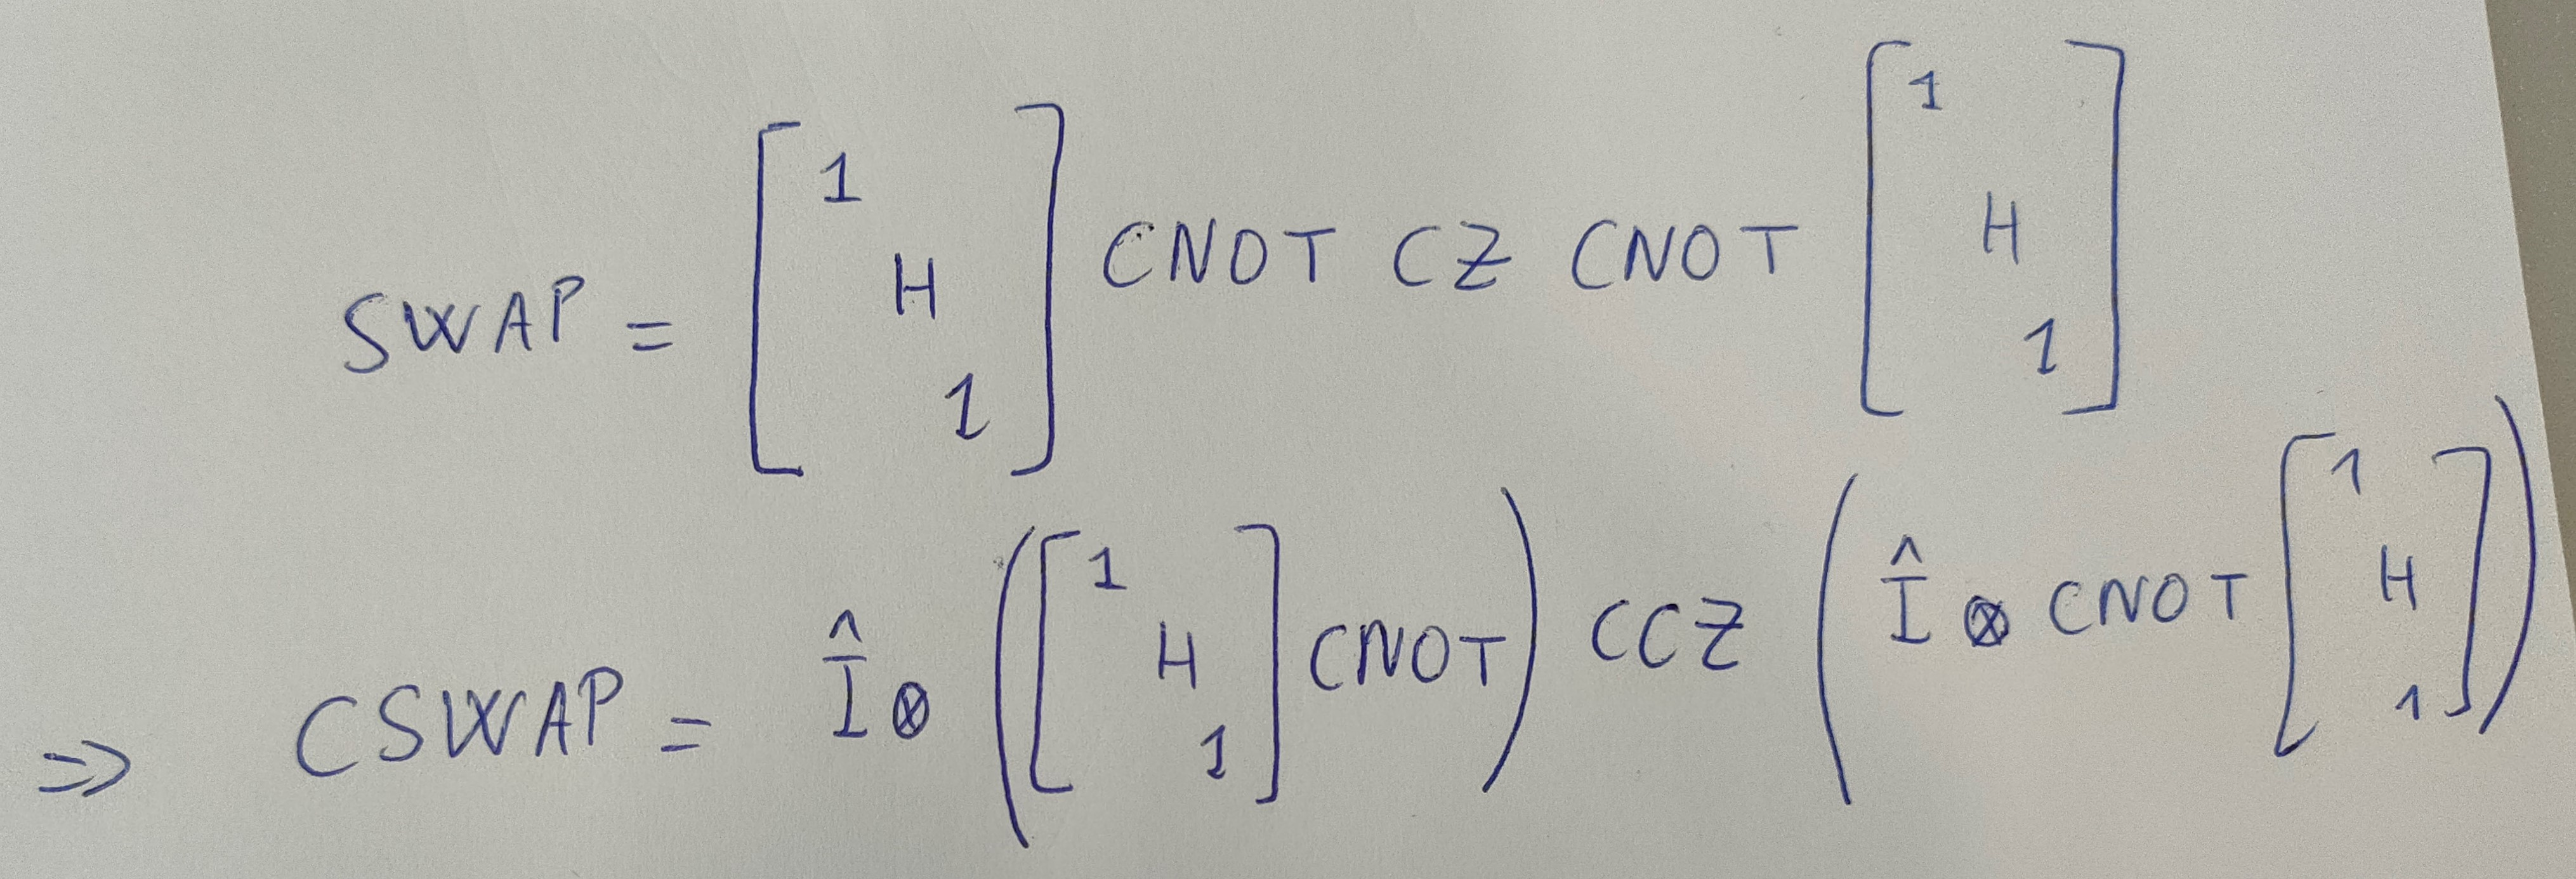

In [484]:
def CSWAP():
    circ=pcvl.Circuit(8,name="CSWAP")
    circ.add((3,4),phys.BS(R=1/2))
    circ.add(2, CNOT())
    circ.add((0,1,2,3,4,5,6,7),phys.PERM([7,0,6,5,4,2,1,3]))
    circ.add(0,KZ())
    circ.add((0,1,2,3,4,5,6,7),phys.PERM([1,5,6,7,4,3,2,0]))
    circ.add(2, CNOT())
    circ.add((3,4),phys.BS(R=1/2))
    return circ

In [686]:
circ=CSWAP()
pcvl.pdisplay(circ,recursive=True)

In [486]:
circ=CSWAP()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_test=pcvl.BasicState([0,1,0,1,0,0,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_test):
    print(state, complex(prob).real)

|4,0,0,0,0,0,0,0> 0.0
|3,1,0,0,0,0,0,0> 0.0
|3,0,1,0,0,0,0,0> 0.0
|3,0,0,1,0,0,0,0> 0.0
|3,0,0,0,1,0,0,0> 0.0
|3,0,0,0,0,1,0,0> 0.0
|3,0,0,0,0,0,1,0> 0.0
|3,0,0,0,0,0,0,1> 0.0
|2,2,0,0,0,0,0,0> 0.0
|2,1,1,0,0,0,0,0> 0.0
|2,1,0,1,0,0,0,0> 0.0
|2,1,0,0,1,0,0,0> 0.0
|2,1,0,0,0,1,0,0> 0.0
|2,1,0,0,0,0,1,0> 0.0
|2,1,0,0,0,0,0,1> 0.0
|2,0,2,0,0,0,0,0> 0.0
|2,0,1,1,0,0,0,0> 0.0
|2,0,1,0,1,0,0,0> 0.0
|2,0,1,0,0,1,0,0> 0.0
|2,0,1,0,0,0,1,0> 0.0
|2,0,1,0,0,0,0,1> 0.0
|2,0,0,2,0,0,0,0> 0.0
|2,0,0,1,1,0,0,0> 0.0
|2,0,0,1,0,1,0,0> 0.0
|2,0,0,1,0,0,1,0> 0.0
|2,0,0,1,0,0,0,1> 0.0
|2,0,0,0,2,0,0,0> 0.0
|2,0,0,0,1,1,0,0> 0.0
|2,0,0,0,1,0,1,0> 0.0
|2,0,0,0,1,0,0,1> 0.0
|2,0,0,0,0,2,0,0> 0.0
|2,0,0,0,0,1,1,0> 0.0
|2,0,0,0,0,1,0,1> 0.0
|2,0,0,0,0,0,2,0> 0.0
|2,0,0,0,0,0,1,1> 0.0
|2,0,0,0,0,0,0,2> 0.0
|1,3,0,0,0,0,0,0> 0.0
|1,2,1,0,0,0,0,0> 0.0
|1,2,0,1,0,0,0,0> 0.0
|1,2,0,0,1,0,0,0> 0.0
|1,2,0,0,0,1,0,0> 0.0
|1,2,0,0,0,0,1,0> 0.0
|1,2,0,0,0,0,0,1> 0.0
|1,1,2,0,0,0,0,0> 0.0
|1,1,1,1,0,0,0,0> 0.0
|1,1,1,0,1

In [323]:
circ=CSWAP()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_test=pcvl.BasicState([1,0,0,1,0,0,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_test):
    print(state, complex(prob).real)

|4,0,0,0,0,0,0,0> 0.0
|3,1,0,0,0,0,0,0> 0.0
|3,0,1,0,0,0,0,0> 0.0
|3,0,0,1,0,0,0,0> 0.0
|3,0,0,0,1,0,0,0> 0.0
|3,0,0,0,0,1,0,0> 0.0
|3,0,0,0,0,0,1,0> 0.0
|3,0,0,0,0,0,0,1> 0.0
|2,2,0,0,0,0,0,0> 0.0
|2,1,1,0,0,0,0,0> 0.0
|2,1,0,1,0,0,0,0> 0.0
|2,1,0,0,1,0,0,0> 0.0
|2,1,0,0,0,1,0,0> 0.0
|2,1,0,0,0,0,1,0> 0.0
|2,1,0,0,0,0,0,1> 0.0
|2,0,2,0,0,0,0,0> 0.0
|2,0,1,1,0,0,0,0> 0.0
|2,0,1,0,1,0,0,0> 0.0
|2,0,1,0,0,1,0,0> 0.0
|2,0,1,0,0,0,1,0> 0.0
|2,0,1,0,0,0,0,1> 0.0
|2,0,0,2,0,0,0,0> 0.0
|2,0,0,1,1,0,0,0> 0.0
|2,0,0,1,0,1,0,0> 0.0
|2,0,0,1,0,0,1,0> 0.0
|2,0,0,1,0,0,0,1> 0.0
|2,0,0,0,2,0,0,0> 0.0
|2,0,0,0,1,1,0,0> 0.0
|2,0,0,0,1,0,1,0> 0.0
|2,0,0,0,1,0,0,1> 0.0
|2,0,0,0,0,2,0,0> 0.0
|2,0,0,0,0,1,1,0> 0.0
|2,0,0,0,0,1,0,1> 0.0
|2,0,0,0,0,0,2,0> 0.0
|2,0,0,0,0,0,1,1> 0.0
|2,0,0,0,0,0,0,2> 0.0
|1,3,0,0,0,0,0,0> 0.06584362139917695
|1,2,1,0,0,0,0,0> 0.0
|1,2,0,1,0,0,0,0> 0.049382716049382866
|1,2,0,0,1,0,0,0> 0.0493827160493825
|1,2,0,0,0,1,0,0> 0.0
|1,2,0,0,0,0,1,0> 0.04485176743031428
|1,2,0,0,0,0

In [324]:
circ=CSWAP()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_test=pcvl.BasicState([0,1,1,0,0,0,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_test):
    print(state, complex(prob).real)

|4,0,0,0,0,0,0,0> 0.0
|3,1,0,0,0,0,0,0> 0.0
|3,0,1,0,0,0,0,0> 0.0
|3,0,0,1,0,0,0,0> 0.0
|3,0,0,0,1,0,0,0> 0.0
|3,0,0,0,0,1,0,0> 0.0
|3,0,0,0,0,0,1,0> 0.0
|3,0,0,0,0,0,0,1> 0.0
|2,2,0,0,0,0,0,0> 0.0
|2,1,1,0,0,0,0,0> 0.0
|2,1,0,1,0,0,0,0> 0.0
|2,1,0,0,1,0,0,0> 0.0
|2,1,0,0,0,1,0,0> 0.0
|2,1,0,0,0,0,1,0> 0.0
|2,1,0,0,0,0,0,1> 0.0
|2,0,2,0,0,0,0,0> 0.0
|2,0,1,1,0,0,0,0> 0.0
|2,0,1,0,1,0,0,0> 0.0
|2,0,1,0,0,1,0,0> 0.0
|2,0,1,0,0,0,1,0> 0.0
|2,0,1,0,0,0,0,1> 0.0
|2,0,0,2,0,0,0,0> 0.0
|2,0,0,1,1,0,0,0> 0.0
|2,0,0,1,0,1,0,0> 0.0
|2,0,0,1,0,0,1,0> 0.0
|2,0,0,1,0,0,0,1> 0.0
|2,0,0,0,2,0,0,0> 0.0
|2,0,0,0,1,1,0,0> 0.0
|2,0,0,0,1,0,1,0> 0.0
|2,0,0,0,1,0,0,1> 0.0
|2,0,0,0,0,2,0,0> 0.0
|2,0,0,0,0,1,1,0> 0.0
|2,0,0,0,0,1,0,1> 0.0
|2,0,0,0,0,0,2,0> 0.0
|2,0,0,0,0,0,1,1> 0.0
|2,0,0,0,0,0,0,2> 0.0
|1,3,0,0,0,0,0,0> 0.0
|1,2,1,0,0,0,0,0> 0.0
|1,2,0,1,0,0,0,0> 0.0
|1,2,0,0,1,0,0,0> 0.0
|1,2,0,0,0,1,0,0> 0.0
|1,2,0,0,0,0,1,0> 0.0
|1,2,0,0,0,0,0,1> 0.0
|1,1,2,0,0,0,0,0> 0.0
|1,1,1,1,0,0,0,0> 0.0
|1,1,1,0,1

In [487]:
circ=CSWAP()
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_test=pcvl.BasicState([0,1,1,0,0,0,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_test):
    print(state, complex(prob).real)

|4,0,0,0,0,0,0,0> 0.0
|3,1,0,0,0,0,0,0> 0.0
|3,0,1,0,0,0,0,0> 0.0
|3,0,0,1,0,0,0,0> 0.0
|3,0,0,0,1,0,0,0> 0.0
|3,0,0,0,0,1,0,0> 0.0
|3,0,0,0,0,0,1,0> 0.0
|3,0,0,0,0,0,0,1> 0.0
|2,2,0,0,0,0,0,0> 0.0
|2,1,1,0,0,0,0,0> 0.0
|2,1,0,1,0,0,0,0> 0.0
|2,1,0,0,1,0,0,0> 0.0
|2,1,0,0,0,1,0,0> 0.0
|2,1,0,0,0,0,1,0> 0.0
|2,1,0,0,0,0,0,1> 0.0
|2,0,2,0,0,0,0,0> 0.0
|2,0,1,1,0,0,0,0> 0.0
|2,0,1,0,1,0,0,0> 0.0
|2,0,1,0,0,1,0,0> 0.0
|2,0,1,0,0,0,1,0> 0.0
|2,0,1,0,0,0,0,1> 0.0
|2,0,0,2,0,0,0,0> 0.0
|2,0,0,1,1,0,0,0> 0.0
|2,0,0,1,0,1,0,0> 0.0
|2,0,0,1,0,0,1,0> 0.0
|2,0,0,1,0,0,0,1> 0.0
|2,0,0,0,2,0,0,0> 0.0
|2,0,0,0,1,1,0,0> 0.0
|2,0,0,0,1,0,1,0> 0.0
|2,0,0,0,1,0,0,1> 0.0
|2,0,0,0,0,2,0,0> 0.0
|2,0,0,0,0,1,1,0> 0.0
|2,0,0,0,0,1,0,1> 0.0
|2,0,0,0,0,0,2,0> 0.0
|2,0,0,0,0,0,1,1> 0.0
|2,0,0,0,0,0,0,2> 0.0
|1,3,0,0,0,0,0,0> 0.0
|1,2,1,0,0,0,0,0> 0.0
|1,2,0,1,0,0,0,0> 0.0
|1,2,0,0,1,0,0,0> 0.0
|1,2,0,0,0,1,0,0> 0.0
|1,2,0,0,0,0,1,0> 0.0
|1,2,0,0,0,0,0,1> 0.0
|1,1,2,0,0,0,0,0> 0.0
|1,1,1,1,0,0,0,0> 0.0
|1,1,1,0,1

### General CCCU circuit

Our implementation of the CCCZ gate allows us to implement any CCCU gate, provided that the $U$ gate can be written in the form:

\begin{equation*}
U = V^\dagger Z V
\end{equation*}

It is easy to see that $U$ is a unitary Hermitian matrix. Additionally, provided that we know how to implement the $V^\dagger$ and $V$ gates on the second qubit of a qu-4-it, we can use our implementation of the CCCZ gate in order to implement the CCCU gate.

In [616]:
def CCCU(circ_V, circ_V_dag):
    circ = phys.Circuit(10, name="CCCU")
    circ.add(4, circ_V())
    circ.add(0,CCCZ())
    circ.add(4, circ_V_dag())
    return circ

#### CCCX

In [688]:
circ=CCCU(H1,H1)
pcvl.pdisplay(circ,recursive=True)

In [618]:
circ=CCCU(H1,H1)
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_test=pcvl.BasicState([0,0,0,1,0,0,0,1,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_test):
    print(state, complex(prob).real)

|4,0,0,0,0,0,0,0,0,0> 0.0
|3,1,0,0,0,0,0,0,0,0> 0.0
|3,0,1,0,0,0,0,0,0,0> 0.0
|3,0,0,1,0,0,0,0,0,0> 0.0
|3,0,0,0,1,0,0,0,0,0> 0.0
|3,0,0,0,0,1,0,0,0,0> 0.0
|3,0,0,0,0,0,1,0,0,0> 0.0
|3,0,0,0,0,0,0,1,0,0> 0.0
|3,0,0,0,0,0,0,0,1,0> 0.0
|3,0,0,0,0,0,0,0,0,1> 0.0
|2,2,0,0,0,0,0,0,0,0> 0.0
|2,1,1,0,0,0,0,0,0,0> 0.0
|2,1,0,1,0,0,0,0,0,0> 0.0
|2,1,0,0,1,0,0,0,0,0> 0.0
|2,1,0,0,0,1,0,0,0,0> 0.0
|2,1,0,0,0,0,1,0,0,0> 0.0
|2,1,0,0,0,0,0,1,0,0> 0.0
|2,1,0,0,0,0,0,0,1,0> 0.0
|2,1,0,0,0,0,0,0,0,1> 0.0
|2,0,2,0,0,0,0,0,0,0> 0.0
|2,0,1,1,0,0,0,0,0,0> 0.0
|2,0,1,0,1,0,0,0,0,0> 0.0
|2,0,1,0,0,1,0,0,0,0> 0.0
|2,0,1,0,0,0,1,0,0,0> 0.0
|2,0,1,0,0,0,0,1,0,0> 0.0
|2,0,1,0,0,0,0,0,1,0> 0.0
|2,0,1,0,0,0,0,0,0,1> 0.0
|2,0,0,2,0,0,0,0,0,0> 0.0
|2,0,0,1,1,0,0,0,0,0> 0.0
|2,0,0,1,0,1,0,0,0,0> 0.0
|2,0,0,1,0,0,1,0,0,0> 0.0
|2,0,0,1,0,0,0,1,0,0> 0.0
|2,0,0,1,0,0,0,0,1,0> 0.0
|2,0,0,1,0,0,0,0,0,1> 0.0
|2,0,0,0,2,0,0,0,0,0> 0.0
|2,0,0,0,1,1,0,0,0,0> 0.0
|2,0,0,0,1,0,1,0,0,0> 0.0
|2,0,0,0,1,0,0,1,0,0> 0.0
|2,0,0,0,1,0

In [619]:
circ=CCCU(H1,H1)
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state_test=pcvl.BasicState([0,0,0,1,0,1,0,0,1,1]) 
s1 = simulator_backend(circ.U)
for state, prob in s1.allstateprob_iterator(input_state_test):
    print(state, complex(prob).real)

|4,0,0,0,0,0,0,0,0,0> 0.0
|3,1,0,0,0,0,0,0,0,0> 0.0
|3,0,1,0,0,0,0,0,0,0> 0.0
|3,0,0,1,0,0,0,0,0,0> 0.0
|3,0,0,0,1,0,0,0,0,0> 0.0
|3,0,0,0,0,1,0,0,0,0> 0.0
|3,0,0,0,0,0,1,0,0,0> 0.0
|3,0,0,0,0,0,0,1,0,0> 0.0
|3,0,0,0,0,0,0,0,1,0> 0.0
|3,0,0,0,0,0,0,0,0,1> 0.0
|2,2,0,0,0,0,0,0,0,0> 0.0
|2,1,1,0,0,0,0,0,0,0> 0.0
|2,1,0,1,0,0,0,0,0,0> 0.0
|2,1,0,0,1,0,0,0,0,0> 0.0
|2,1,0,0,0,1,0,0,0,0> 0.0
|2,1,0,0,0,0,1,0,0,0> 0.0
|2,1,0,0,0,0,0,1,0,0> 0.0
|2,1,0,0,0,0,0,0,1,0> 0.0
|2,1,0,0,0,0,0,0,0,1> 0.0
|2,0,2,0,0,0,0,0,0,0> 0.0
|2,0,1,1,0,0,0,0,0,0> 0.0
|2,0,1,0,1,0,0,0,0,0> 0.0
|2,0,1,0,0,1,0,0,0,0> 0.0
|2,0,1,0,0,0,1,0,0,0> 0.0
|2,0,1,0,0,0,0,1,0,0> 0.0
|2,0,1,0,0,0,0,0,1,0> 0.0
|2,0,1,0,0,0,0,0,0,1> 0.0
|2,0,0,2,0,0,0,0,0,0> 0.0
|2,0,0,1,1,0,0,0,0,0> 0.0
|2,0,0,1,0,1,0,0,0,0> 0.0
|2,0,0,1,0,0,1,0,0,0> 0.0
|2,0,0,1,0,0,0,1,0,0> 0.0
|2,0,0,1,0,0,0,0,1,0> 0.0
|2,0,0,1,0,0,0,0,0,1> 0.0
|2,0,0,0,2,0,0,0,0,0> 0.0
|2,0,0,0,1,1,0,0,0,0> 0.0
|2,0,0,0,1,0,1,0,0,0> 0.0
|2,0,0,0,1,0,0,1,0,0> 0.0
|2,0,0,0,1,0

#### CCCY

In [620]:
def H_tilde_1():
    circ=phys.Circuit(4, name="H_tilde")
    circ.add((0, 1), phys.BS(R=1/2,phi_a=0,phi_b=-np.pi/2,phi_d=-np.pi/2))
    circ.add((2, 3), phys.BS(R=1/2,phi_a=0,phi_b=-np.pi/2,phi_d=-np.pi/2))
    return circ

def H_tilde_dag1():
    circ=phys.Circuit(4, name="H_tilde_dag")
    circ.add((0, 1), phys.BS(R=1/2, phi_a=0,phi_b=-np.pi,phi_d=np.pi/2))
    circ.add((2, 3), phys.BS(R=1/2, phi_a=0,phi_b=-np.pi,phi_d=np.pi/2))
    return circ

In [690]:
circ=CCCU(H_tilde_1,H_tilde_dag1)
pcvl.pdisplay(circ,recursive=True)

#### $\text{CCCU}_{\text{x}}$

This gate defines the triply-controlled Z gate operation after applying a rotation along the $\text{x}-$axis. This operation can be written as:

\begin{equation*}
\text{R}_{\text{x}}(\theta) \ \text{Z} \ \text{R}_{\text{x}}(-\theta) =\begin{pmatrix}
                                                                   \text{cos}(\theta) & i \ \text{sin}(\theta)\\
                                                                   -i \ \text{sin}(\theta) & -\text{cos}(\theta)
                                                                   \end{pmatrix}
\end{equation*}

In [624]:
def CCCU_x(theta):
    circ_V=lambda:R_x1(-theta)
    circ_V_dag=lambda:R_x1(theta)
    return CCCU(circ_V, circ_V_dag)

In [692]:
circ=CCCU_x(np.pi/3)
pcvl.pdisplay(circ,recursive=True)

#### $\text{CCCU}_{\text{y}}$

This gate defines the triply-controlled Z gate operation after applying a rotation along the $\text{y}-$axis. This operation can be written as:

\begin{equation*}
\text{R}_{\text{y}}(\theta) \ \text{Z} \ \text{R}_{\text{y}}(-\theta) =\begin{pmatrix}
                                                                   \text{cos}(\theta) & \text{sin}(\theta)\\
                                                                   \text{sin}(\theta) & -\text{cos}(\theta)
                                                                   \end{pmatrix}
\end{equation*}

In [626]:
def CCCU_y(theta):
    circ_V=lambda:R_y1(-theta)
    circ_V_dag=lambda:R_y1(theta)
    return CCCU(circ_V, circ_V_dag)

In [693]:
circ=CCCU_y(np.pi/3)
pcvl.pdisplay(circ, recursive=True)

### General CCU circuit

Our implementation of the hybrid CCZ gate allows us to implement any CCU gate, provided that the $U$ gate can be written in the form:

\begin{equation*}
U = V^\dagger Z V
\end{equation*}

It is easy to see that $U$ is a unitary Hermitian matrix. Additionally, provided that we know how to implement the $V^\dagger$ and $V$ gates on a dual rail qubit (which can be done using Perceval's convertor), we can use our implementation of the CCZ gate in order to implement the CCU gate.

In [631]:
def CCU(circ_V, circ_V_dag):
    circ = phys.Circuit(8, name="CCU")
    circ.add(4, circ_V())
    circ.add((0,1,2,3,4,5,6,7), phys.PERM([7,6,5,0,4,2,1,3]))
    circ.add(0, KZ())
    circ.add((0,1,2,3,4,5,6,7), phys.PERM([3,5,6,7,4,2,1,0]))
    circ.add(4, circ_V_dag())
    return circ

#### CCX circuit

In [632]:
def dual_H():
    return phys.BS()

In [694]:
circ=CCU(dual_H,dual_H)
pcvl.pdisplay(circ,recursive=True)

#### CCY circuit

In [636]:
def dual_H_tilde():
    return phys.BS(R=1/2, phi_a=0,phi_b=-np.pi/2,phi_d=-np.pi/2)
def dual_H_tilde_dag():
    return phys.BS(R=1/2, phi_a=0, phi_b=-np.pi,phi_d=np.pi/2)

In [695]:
circ=CCU(dual_H_tilde,dual_H_tilde_dag)
pcvl.pdisplay(circ,recursive=True)

#### $\text{CCU}_{\text{x}}$

This gate defines the doubly-controlled Z gate operation after applying a rotation along the $\text{x}-$axis. This operation can be written as:

\begin{equation*}
\text{R}_{\text{x}}(\theta) \ \text{Z} \ \text{R}_{\text{x}}(-\theta) =\begin{pmatrix}
                                                                   \text{cos}(\theta) & i \ \text{sin}(\theta)\\
                                                                   -i \ \text{sin}(\theta) & -\text{cos}(\theta)
                                                                   \end{pmatrix}
\end{equation*}

In [638]:
def CCU_x(theta):
    circ_V=lambda:R_x1(-theta)
    circ_V_dag=lambda:R_x1(theta)
    return CCCU(circ_V, circ_V_dag)

In [697]:
circ=CCU_x(np.pi/12)
pcvl.pdisplay(circ,recursive=True)

#### $\text{CCU}_{\text{y}}$

This gate defines the doubly-controlled Z gate operation after applying a rotation along the $\text{y}-$axis. This operation can be written as:

\begin{equation*}
\text{R}_{\text{y}}(\theta) \ \text{Z} \ \text{R}_{\text{y}}(-\theta) =\begin{pmatrix}
                                                                   \text{cos}(\theta) & \text{sin}(\theta)\\
                                                                   \text{sin}(\theta) & -\text{cos}(\theta)
                                                                   \end{pmatrix}
\end{equation*}

In [640]:
def CCU_y(theta):
    circ_V=lambda:R_y1(-theta)
    circ_V_dag=lambda:R_y1(theta)
    return CCU(circ_V, circ_V_dag)

In [698]:
circ=CCU_y(3*np.pi/11)
pcvl.pdisplay(circ,recursive=True)

## Example: the kNN circuit

We illustrate our gates using the k-nearest neighbors algorithm. The *normalized* bi-dimensional data points are encoded by their angle to the positive $\text{x}-$axis. The vectors are represented as **qubit states**.

We can therefore apply a simple swap test, which is defined by the following circuit.

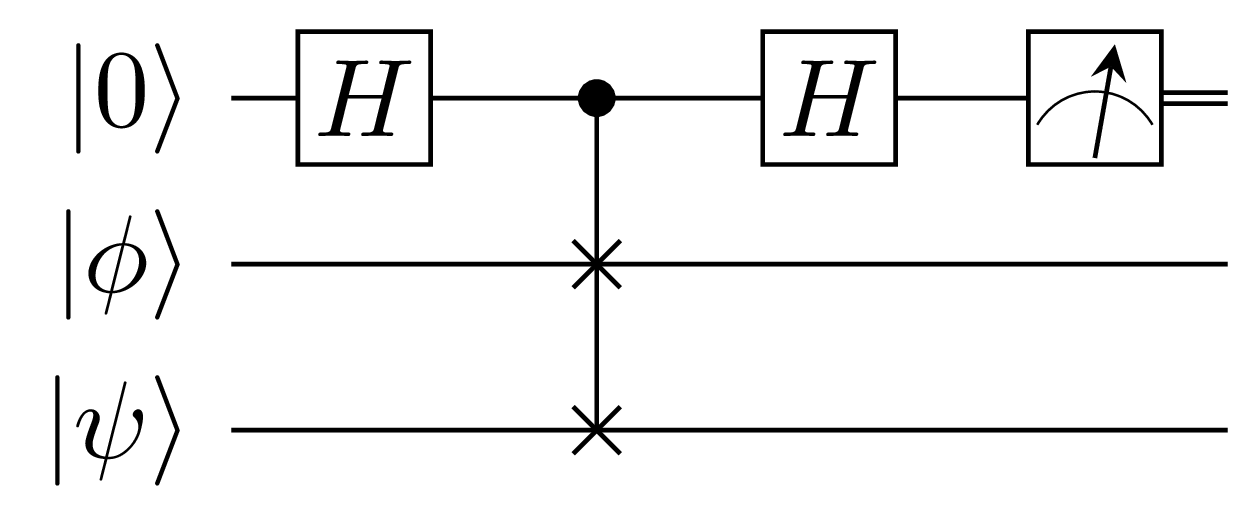

The probability of measuring $0$ in the first qubit is given by:

\begin{equation*}
\mathbb{P}(c_0 = 0)=\frac{1}{2} (1 + |<\psi|\phi>|^2).
\end{equation*}

Consequently:

\begin{equation*}
\mathbb{P}(c_0 = 1)=\frac{1}{2} (1 - |<\psi|\phi>|^2).
\end{equation*}

Hence:

\begin{equation*}
\sqrt{\mathbb{P}(c_0 = 0) - \mathbb{P}(c_0 = 1)} = |<\psi|\phi>|
\end{equation*}

This quantity is what we call: **fidelity**. It is $1$ when the states are the same (up to a phase) and zero if they are orthogonal.

#### Qiskit circuit

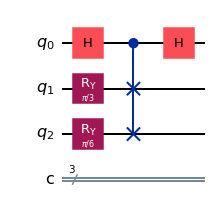

In [488]:
qc = qiskit.QuantumCircuit(3,3)
qc.h(0)
qc.ry(np.pi/3,1)
qc.ry(np.pi/6,2)
qc.cswap(0,1,2)
qc.h(0)
qc.draw("mpl", style="iqx")

#### Perceval circuit

In [489]:
m=8
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state=pcvl.BasicState([1,0,1,0,0,0,1,1]) # dual rail + qu-4-it + 2 ancillas
s1 = simulator_backend(pcvl.Matrix.random_unitary(m)) # some matrix that will be changed later
s1.compile(input_state) 

True

In [490]:
def circ_kNN(theta1,theta2):
    circ=pcvl.Circuit(8,name="kNN_circuit")
    circ.add((0,1),phys.BS()) # Hadamard gate
    circ.add(2,R_y0(theta1))
    circ.add(2,R_y1(theta2))
    circ.add(0,CSWAP())
    circ.add((0,1),phys.BS()) # Hadamard gate
    return circ

In [700]:
circ=circ_kNN(np.pi/3,np.pi/6)
pcvl.pdisplay(circ,recursive=True)

#### Angle definition

In [492]:
def theta_value(vector):
    assert len(vector)==2, "We have only defined the circuit in the case of bi-dimensional vectors"
    norm_vect=np.linalg.norm(vector)
    if norm_vect==0: return 0
    if vector[0] < 0:
        return 2*(np.pi-np.arcsin(vector[1]/norm_vect))
    return 2*np.arcsin(vector[1]/norm_vect)

In [493]:
def create_circuit(vector1, vector2):
    circ=circ_kNN(theta_value(vector1),theta_value(vector2))
    s1.U=circ.U

##### Computing the fidelity

We use our circuit in order to compute the fidelity of our circuit, which measures the proximity between the two states. The fidelity is given by:

\begin{equation*}
\mathcal{F}=\sqrt{\mathbb{P}(c_0 = 0) - \mathbb{P}(c_0 = 1)}
\end{equation*}

The highest value being $1$ (the two states are the same) and the lowest being $0$ (the two states are orthogonal).

In [494]:
def swap_test(vector1,vector2): # we apply post-selection
    probs=[0,0,0]
    create_circuit(vector1, vector2)
    for state, prob in s1.allstateprob_iterator(input_state):
        state_array=np.array(state)
        if state[6]!=1 or state[7]!=1: # we test that the knill CZ worked
            continue
        if state[0]==1 and state[1]==0:
            probs[2]+=complex(prob).real
            probs[0]+=complex(prob).real
        elif state[0]==0 and state[1]==1:
            probs[2]+=complex(prob).real
            probs[1]+=complex(prob).real
    print("Probability of success:", probs[2])
    return np.sqrt(probs[0]-probs[1])

In [495]:
def get_fidelity(vector1, vector2):
    """Run ist circuit many times
    Args:
        - vector1 (numpy array): First vector, don't need to normalize
        - vector2 (numpy array): Second vector, don't need to normalize
    Returns:
        - Float: mean fidelity
    """
    fidelities = np.array([])
    fidelity = swap_test(vector1,vector2)
    fidelities = np.append(fidelities, fidelity)
    return np.average(fidelities)

##### Majority rule

The $\text{k}-$nearest neighbor method assigns the most present class among the $\text{k}-$nearest neighbor of the point to classify. The following function allows us to respect this rule.

In [496]:
def get_major_vote(labels):
    """Get major label value
    Args:
        labels (list): list of value
    Returns:
        int: major vote
    """
    x = collections.Counter(labels)
    return x.most_common(1)[0][0]

##### Nearest rule

The function below implements the classification of the distances to the points of the training set. The classification is done from the highest to the lowest *fidelity*.

In [497]:
def sort_return_index(xs):
    """Note that we must sort from large to small, because scalar product between 
    two similar vectors is almost 1 (other wise with Eucliean distance).
    Args:
        xs (list): list of scalar products between train vectors and one test vector
    Returns:
        list: sorted list but return indices 
    """
    new_xs = sorted(range(len(xs)), key=lambda k: xs[k])
    new_xs.reverse()
    return new_xs

In [498]:
def get_sublist_with_indices(xs, indices, k):
    return [xs[index] for index in indices][:k]

As can be deduced from above, the distance between a pair of states is defined from the *fidelity* of a pair (**the higher the fidelity, the lower the distance**).

In [499]:
def distances(xs, yss):
    """Return a lots of distance
    Args:
        - xs (list of float): vector
        - yss (list of list): dataset
    Returns:
        - list of values: all distances from vector to others vector in data set
    """
    distances = []
    for ys in yss:
        distances.append(get_fidelity(vector1 = xs, vector2 = ys))
    return distances

##### Prediction process

The prediction process for a new point follows the steps below:

1. Computation of the fidelity between the new point and the training points.
2. Finding the $\text{k}-$training points with the *highest* fidelity.
3. Apply the majority rule on the aforementioned $\text{k}-$training points.

In [500]:
def predict(train_datas, train_labels, test_datas, k: int = 1):
    """
    Return predicted labels QKNN algorithm
    Args:
        - train_datas (numpy array 2D): Vectors in train data
        - train_labels (numpy array 1D): Labels in train data
        - test_datas (numpy array 2D): Vectors in test data
        - k (int): Number of neighboors
    Returns:
        - list of int: predicted labels
    """
    print(">>> Predicting")
    predict_labels = []
    for i, test_data in enumerate(test_datas):
        print(i)
        xs = distances(test_data, train_datas)
        indices_of_sorted_xs = sort_return_index(xs)
        labels = get_sublist_with_indices(train_labels, indices_of_sorted_xs, k)
        predict_labels.append(get_major_vote(labels))
    return predict_labels

##### Benchmarking

We use the ```sklearn.metrics``` metrics in order to bemchmark our classifier.

In [501]:
def benchmark(ground_truth, predict):
    """Return predict labels QKNN algorithm
    Args:
        - ground_truth (numpy array 1D): truth labels
        - predict (numpy array 1D): predict labels
    Returns:
        - Tuple: benchmark on classifer problem
    """
    accuracy = sm.accuracy_score(ground_truth, predict)
    precision = sm.precision_score(ground_truth, predict, average="weighted")
    recall = sm.recall_score(ground_truth, predict, average="weighted")
    f1 = sm.f1_score(ground_truth, predict, average="micro")
    matrix = sm.confusion_matrix(ground_truth, predict)
    return accuracy, precision, recall, matrix

##### Data encoding

In [502]:
def encode(xss):
    """Convert normal vector to normalized state
    Args:
        xss (list of list): dataset
    Returns:
        list of list: normalized dataset
    """
    amplitudes = np.sqrt(np.einsum('ij,ij->i', xss, xss))
    amplitudes[amplitudes == 0] = 1
    normalised_data = xss / amplitudes[:, np.newaxis]
    return normalised_data

In what follows, we provide different tests for our method. As one may see, the quality of the classification depends greatly on the type of data sets. Indeed, the k-NN method fails for the following cases:

1. the classes are not well-clusters. In this case, the distance may not provide the relevant information.
2. the point to classify is far from the clusters. Using the distance in order to classify is meaningless.

##### Test 1: iris data set

In [341]:
# hyperparameter
n_variables = 2
n_train_points = 5
n_test_points = 5
k = 1

In [342]:
# use iris dataset
iris = datasets.load_iris()
labels = iris.target
data_raw = iris.data

# encode data
data_raw = encode(data_raw[:, 1:n_variables+1])

# get training indices
randomIndices0 = rd.sample(range(0, 50), int(n_train_points/3))
randomIndices1 = rd.sample(range(55, 100), int(n_train_points/3))
randomIndices2 = rd.sample(range(105, 150), n_train_points-int(n_train_points/3)*2)
indicsTrain = list(itertools.chain(randomIndices0, randomIndices1, randomIndices2))

# get test indices
n_test = n_test_points
indicsTest = []
while n_test != 0:
    random = (rd.sample(range(0, 150), 1))[0]
    if random not in indicsTest:
        indicsTest.append(random)
        n_test = n_test - 1

# pick these state and its labels with given indices
train_datas = np.asarray([data_raw[i] for i in indicsTrain])
train_labels =  np.asarray([labels[i] for i in indicsTrain])
test_datas = np.asarray([data_raw[i] for i in indicsTest])
test_labels =  np.asarray([labels[i] for i in indicsTest])

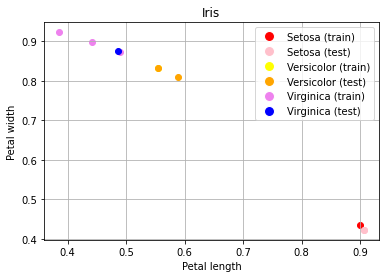

In [343]:
# plot data
train_colors = {0:'red', 1:'yellow', 2:'violet'}
test_colors = {0:'pink', 1:'orange', 2:'blue'}
fig, ax = plt.subplots()
for i in range(len(train_datas)):
    ax.scatter(train_datas[i][0], train_datas[i][1], color = train_colors[train_labels[i]])
for i in range(len(test_datas)):
    ax.scatter(test_datas[i][0], test_datas[i][1], color = test_colors[test_labels[i]])
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Setosa (train)',  markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Setosa (test)',  markerfacecolor='pink', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Versicolor (train)',  markerfacecolor='yellow', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Versicolor (test)',  markerfacecolor='orange', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Virginica (train)',  markerfacecolor='violet', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Virginica (test)',  markerfacecolor='blue', markersize=10),
]
ax.legend(handles=legend_elements)
plt.title('Iris')
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.grid(True)
plt.show()

In [349]:
# run QkNN
predict_labels = np.asarray(predict(train_datas, train_labels, test_datas, k))
accuracy, precision, recall, matrix = benchmark(test_labels, predict_labels)
print('Predict labels: ', predict_labels)
print('Test labels: ', test_labels)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('matrix: ', matrix)

>>> Predicting
0
Probability of success: 0.07407407407407411
Probability of success: 0.0740740740740741
Probability of success: 0.0740740740740741
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407415
1
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407414
Probability of success: 0.07407407407407413
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407414
2
Probability of success: 0.07407407407407415
Probability of success: 0.0740740740740741
Probability of success: 0.07407407407407413
Probability of success: 0.07407407407407413
Probability of success: 0.07407407407407414
3
Probability of success: 0.0740740740740741
Probability of success: 0.07407407407407414
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407408
Probability of success: 0.07407407407407413
4
Probability of success: 0.0740740740740741
Probability of success: 0.07407407407407414
Probability 

##### Test 2: linear data set

In [503]:
# hyperparameter
k = 1
N=20

In [504]:
X, y = datasets.make_blobs(n_samples=N, centers=2, n_features=2)
train_datas=X[:N//2]
test_datas=X[N//2:]
train_labels=y[:N//2]
test_labels=y[N//2:]

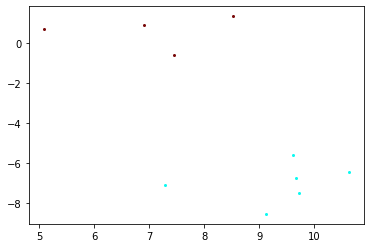

In [505]:
plt.scatter(
    train_datas[train_labels == 0, 0],
    train_datas[train_labels == 0, 1],
    s=4,
    label='0',
    alpha=1, c = ["#0cf9f1"]
)
plt.scatter(
    train_datas[train_labels == 1, 0],
    train_datas[train_labels == 1, 1],
    s=4,
    label='1',
    alpha=1,
    c = ["#790909"]
)
plt.show()

In [506]:
# run QkNN
predict_labels = np.asarray(predict(train_datas, train_labels, test_datas, k))
accuracy, precision, recall, matrix = benchmark(test_labels, predict_labels)
print('Predict labels: ', predict_labels)
print('Test labels: ', test_labels)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('matrix: ', matrix)

>>> Predicting
0
Probability of success: 0.07407407407407414
Probability of success: 0.07407407407407411
Probability of success: 0.0740740740740741
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407413
Probability of success: 0.07407407407407413
Probability of success: 0.07407407407407415
Probability of success: 0.07407407407407414
Probability of success: 0.07407407407407411
1
Probability of success: 0.07407407407407413
Probability of success: 0.07407407407407408
Probability of success: 0.0740740740740741
Probability of success: 0.0740740740740741
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407413
Probability of success: 0.07407407407407414
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407408
2
Probability of success: 0.07407407407407408
Probability of success: 0.07407407407407408
Probability of

##### Test 3: circular data set

In [479]:
# hyperparameter
k = 1
N=20

In [480]:
X, y = datasets.make_circles(n_samples=N, noise=0.03)
train_datas=X[:N//2]
test_datas=X[N//2:]
train_labels=y[:N//2]
test_labels=y[N//2:]

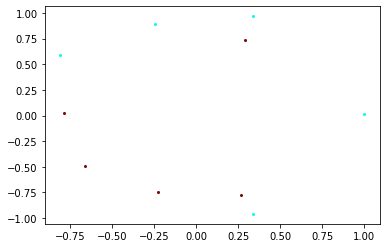

In [481]:
plt.scatter(
    train_datas[train_labels == 0, 0],
    train_datas[train_labels == 0, 1],
    s=4,
    label='0',
    alpha=1, c = ["#0cf9f1"]
)
plt.scatter(
    train_datas[train_labels == 1, 0],
    train_datas[train_labels == 1, 1],
    s=4,
    label='1',
    alpha=1,
    c = ["#790909"]
)
plt.show()

In [507]:
# run QkNN
predict_labels = np.asarray(predict(train_datas, train_labels, test_datas, k))
accuracy, precision, recall, matrix = benchmark(test_labels, predict_labels)
print('Predict labels: ', predict_labels)
print('Test labels: ', test_labels)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('matrix: ', matrix)

>>> Predicting
0
Probability of success: 0.07407407407407414
Probability of success: 0.07407407407407411
Probability of success: 0.0740740740740741
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407413
Probability of success: 0.07407407407407413
Probability of success: 0.07407407407407415
Probability of success: 0.07407407407407414
Probability of success: 0.07407407407407411
1
Probability of success: 0.07407407407407413
Probability of success: 0.07407407407407408
Probability of success: 0.0740740740740741
Probability of success: 0.0740740740740741
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407413
Probability of success: 0.07407407407407414
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407408
2
Probability of success: 0.07407407407407408
Probability of success: 0.07407407407407408
Probability of

##### Test 4: Container Crane Controller Data Set
This test relies on this <a href="https://archive.ics.uci.edu/ml/datasets/Container+Crane+Controller+Data+Set">UCI data set</a>. It associates the speed and angle of the crane to the required power.

In [536]:
# hyperparameter
k = 1
N=20

In [540]:
X=np.array([[1,-5],[2,5],[8,2],[9,0],[3,-2],[1,2],[6,-5],[7,5],[6,-2],[7,2],[8,-5],[9,5],[10,-2]])
y=np.array([0,0,0,0,1,1,1,1,0,0,1,1,0])
train_datas=X[:N//2]
test_datas=X[N//2:]
train_labels=y[:N//2]
test_labels=y[N//2:]

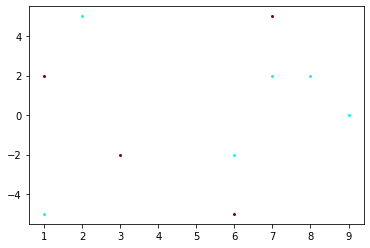

In [541]:
plt.scatter(
    train_datas[train_labels == 0, 0],
    train_datas[train_labels == 0, 1],
    s=4,
    label='0',
    alpha=1, c = ["#0cf9f1"]
)
plt.scatter(
    train_datas[train_labels == 1, 0],
    train_datas[train_labels == 1, 1],
    s=4,
    label='1',
    alpha=1,
    c = ["#790909"]
)
plt.show()

In [542]:
# run QkNN
predict_labels = np.asarray(predict(train_datas, train_labels, test_datas, k))
accuracy, precision, recall, matrix = benchmark(test_labels, predict_labels)
print('Predict labels: ', predict_labels)
print('Test labels: ', test_labels)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('matrix: ', matrix)

>>> Predicting
0
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407408
Probability of success: 0.07407407407407415
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407411
Probability of success: 0.07407407407407414
Probability of success: 0.07407407407407407
Probability of success: 0.0740740740740741
Probability of success: 0.0740740740740741
1
Probability of success: 0.07407407407407413
Probability of success: 0.07407407407407414
Probability of success: 0.0740740740740741
Probability of success: 0.07407407407407413
Probability of success: 0.0740740740740741
Probability of success: 0.07407407407407413
Probability of success: 0.0740740740740741
Probability of success: 0.07407407407407413
Probability of success: 0.0740740740740741
Probability of success: 0.0740740740740741
2
Probability of success: 0.07407407407407408
Probability of success: 0.07407407407407413
Probability of suc

## Sources

We used the following sources:

[1] @article{hai_chuong_bao_2022, 
  title={New approach of KNN algorithm in quantum computing based on new design of Quantum Circuits}, 
  volume={46}, 
  DOI={10.31449/inf.v46i5.3608}, 
  number={5}, 
  journal={Informatica}, 
  author={Hai, Vu Tuan and Chuong, Phan Hoang and Bao, Pham The}, 
  year={2022}, pages={95–103}
}

[2] https://github.com/vutuanhai237/HybridQkNN

[3] https://en.wikipedia.org/wiki/Swap_test